# Description
Train digital backends to classify compressed speed limit sign images by the ONN and optical encoders.

# Load Libraries

In [1]:
from __future__ import print_function
import os, sys
import math
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.optim.lr_scheduler import CosineAnnealingLR
import optuna
import ray

import wandb
from torchvision import datasets, transforms

In [2]:
""" Training and hyperparameter search configurations """

parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=100, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=2000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=5000, metavar='N',
                    help='number of epochs to train (default: 100)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--gpus', default=0,
                    help='gpus used for training - e.g 0,1,3')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--wandb', action='store_true', default=True, 
                    help='enables wandb logger')  
parser.add_argument('--csv', action='store_true', default=False, 
                    help='enables csv logger')  
args = parser.parse_args("")
args.cuda = not args.no_cuda and torch.cuda.is_available()

# Set random seeds to reproduce results
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)


# Dataloaders

In [3]:
""" Construct a dataset object from data. """

class Realscene_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_import, label_import, data_transforms=None):
        self.physical_ground_truth = torch.tensor(data_import, dtype = torch.float32)
        self.labels = torch.tensor(label_import, dtype = torch.long)
        self.class_dict = {}
        self.transform = data_transforms
                
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        data = self.physical_ground_truth[idx]
        
        if self.transform:
             data = self.transform(self.physical_ground_truth[idx].unsqueeze(0))
            
        return data, self.labels[idx]#, self.digital_ground_truth[idx,:]

In [4]:
d = {0:15, 1:25, 2:30, 3:50, 4:70, 5:80, 6:20, 7:55}
angle_range = range(0, 89)

f0 = "Real_Scene_slims_GT_images_total.npz"
f0_np = np.load(f0)
data_GT = f0_np['total_data']
data_labels = f0_np['total_labels']

f1 = 'Speedsign_nonlinear.npz'
f1_np = np.load(f1)
train_fc1 = f1_np['train_fc1']
train_act1 = f1_np['train_act1']
train_fc2 = f1_np['train_fc2']
val_fc1 = f1_np['val_fc1']
val_act1 = f1_np['val_act1']
val_fc2 = f1_np['val_fc2']
test_fc1 = f1_np['test_fc1']
test_act1 = f1_np['test_act1']
test_fc2 = f1_np['test_fc2']
train_labels = f1_np['train_labels']
val_labels = f1_np['val_labels']
test_labels = f1_np['test_labels']

f1 = 'Speedsign_linear.npz'
f1_np = np.load(f1)
train_lin_fc1 = f1_np['train_fc1']
val_lin_fc1 = f1_np['val_fc1']
test_lin_fc1 = f1_np['test_fc1']

In [5]:
""" Prepare data loaders """

transforms_input = transforms.Compose([transforms.Lambda(lambda x: x.view(-1)), \
                                            transforms.Lambda(lambda x: x/150)])

transforms_input_distort = transforms.Compose([transforms.RandomAffine(0, translate=(0.05, 0.05), scale=(0.96, 1.04)), \
                                         transforms.Lambda(lambda x: x.view(-1)), \
                                         transforms.Lambda(lambda x: x/150)])

transforms_act1 = transforms.Compose([transforms.Lambda(lambda x: x.view(-1)), \
                                            transforms.Lambda(lambda x: x/140000*20)])

transforms_fc1 = transforms.Compose([transforms.Lambda(lambda x: x.view(-1)), \
                                            transforms.Lambda(lambda x: x/1E4)])

transforms_fc2 = transforms.Compose([transforms.Lambda(lambda x: x.view(-1)), \
                                            transforms.Lambda(lambda x: x/1E4/5)])

kwargs = {}


""" input image loader w/. customerized samplers """
train_sampler = torch.utils.data.BatchSampler(\
                                              torch.utils.data.RandomSampler(range(train_fc1.shape[0])), \
                                              batch_size=32, drop_last=False)
val_sampler = torch.utils.data.BatchSampler(\
                                             torch.utils.data.RandomSampler(range(val_fc1.shape[0])), \
                                             batch_size=1000, drop_last=False)

# train_loader_phys = torch.utils.data.DataLoader( \
#     Realscene_Dataset(train_GT, train_labels, transforms_input_distort), \
#     batch_sampler = train_sampler, **kwargs)

# test_loader_phys = torch.utils.data.DataLoader( \
#     Realscene_Dataset(test_GT, test_labels, transforms_input), \
#     batch_sampler = test_sampler, **kwargs)

train_loader_fc1 = torch.utils.data.DataLoader( \
    Realscene_Dataset(train_fc1, train_labels, transforms_fc1), \
    batch_sampler = train_sampler, **kwargs)

val_loader_fc1 = torch.utils.data.DataLoader( \
    Realscene_Dataset(val_fc1, test_labels, transforms_fc1), \
    batch_sampler = val_sampler, **kwargs)

train_loader_act1 = torch.utils.data.DataLoader( \
    Realscene_Dataset(train_act1, train_labels, transforms_act1), \
    batch_sampler = train_sampler, **kwargs)

val_loader_act1 = torch.utils.data.DataLoader( \
    Realscene_Dataset(val_act1, test_labels, transforms_act1), \
    batch_sampler = val_sampler, **kwargs)

train_loader_fc2 = torch.utils.data.DataLoader( \
    Realscene_Dataset(train_fc2, train_labels, transforms_fc2), \
    batch_sampler = train_sampler, **kwargs)

val_loader_fc2 = torch.utils.data.DataLoader( \
    Realscene_Dataset(val_fc2, test_labels, transforms_fc2), \
    batch_sampler = val_sampler, **kwargs)

val_lin_loader_fc1 = torch.utils.data.DataLoader( \
    Realscene_Dataset(train_lin_fc1, train_labels, transforms_fc1), \
    batch_sampler = train_sampler, **kwargs)

val_lin_loader_fc1 = torch.utils.data.DataLoader( \
    Realscene_Dataset(val_lin_fc1, test_labels, transforms_fc1), \
    batch_sampler = val_sampler, **kwargs)

#----------------------------------------------

data_size = test_fc1.shape[0]

data_loader_phys_order = torch.utils.data.DataLoader( \
    Realscene_Dataset(data_GT, data_labels, transforms_input), \
    batch_size=89*8, shuffle=False, **kwargs)

# test_loader_phys_order = torch.utils.data.DataLoader( \
#     Realscene_Dataset(test_GT, test_labels, transforms_input), \
#     batch_size=args.test_batch_size, shuffle=False, **kwargs)

test_loader_fc1_order = torch.utils.data.DataLoader( \
    Realscene_Dataset(test_fc1, data_labels, transforms_fc1), \
    batch_size=data_size, shuffle=False, **kwargs)

# test_loader_fc1_order = torch.utils.data.DataLoader( \
#     Realscene_Dataset(test_fc1, test_labels, transforms_fc1), \
#     batch_size=args.test_batch_size, shuffle=False, **kwargs)

test_loader_act1_order = torch.utils.data.DataLoader( \
    Realscene_Dataset(test_act1, data_labels, transforms_act1), \
    batch_size=data_size, shuffle=True, **kwargs)

# test_loader_act1_order = torch.utils.data.DataLoader( \
#     Realscene_Dataset(test_act1, test_labels, transforms_act1), \
#     batch_size=args.test_batch_size, shuffle=True, **kwargs)

test_loader_fc2_order = torch.utils.data.DataLoader( \
    Realscene_Dataset(test_fc2, data_labels, transforms_fc2), \
    batch_size=data_size, shuffle=False, **kwargs)

# test_loader_fc2_order = torch.utils.data.DataLoader( \
#     Realscene_Dataset(test_fc2, test_labels, transforms_fc2), \
#     batch_size=args.test_batch_size, shuffle=False, **kwargs)

test_lin_loader_fc1_order = torch.utils.data.DataLoader( \
    Realscene_Dataset(test_lin_fc1, data_labels, transforms_fc1), \
     batch_size=data_size, shuffle=False, **kwargs)

# test_lin_loader_fc1_order = torch.utils.data.DataLoader( \
#     Realscene_Dataset(test_lin_fc1, test_lin_labels, transforms_fc1), \
#     batch_size=args.test_batch_size, shuffle=False, **kwargs)


In [6]:
print(next(iter(train_loader_fc2))[0].shape)
print(next(iter(val_loader_fc2))[0].shape)
print(next(iter(test_loader_fc2_order))[0].shape)

torch.Size([32, 2])
torch.Size([712, 2])
torch.Size([712, 2])


# NN Definitions

In [7]:
class ONNLinear(nn.Module):
    def __init__(self, in_features, out_features, weight_noise=0.02, zeros_init=False):
        super(ONNLinear, self).__init__()
        self.W_Opt = \
            nn.Parameter(torch.randn(out_features, in_features, requires_grad = True) / math.sqrt(in_features)) \
            if not zeros_init else \
            nn.Parameter(torch.zeros(out_features, in_features, requires_grad = True)) 
        self.noise = weight_noise
        
    def forward(self, x):
        self.W_Opt.data = self.W_Opt.data.clamp_(0,1)
        out = F.linear(x + self.noise*torch.rand(x.shape, requires_grad=False, device=x.device), self.W_Opt)
        return out

def exp(Y, params):
    return torch.exp(-1.*torch.mul(Y, params))

def NL_func(Y, nonlinear_paramters):
    return torch.add(-1.*torch.mul(exp(Y, nonlinear_paramters[:, 1]), nonlinear_paramters[:, 0]) + \
                      -1.*torch.mul(exp(Y, nonlinear_paramters[:, 3]), nonlinear_paramters[:, 2]), \
                      nonlinear_paramters[:, 0]+nonlinear_paramters[:, 2])/50

class ONNIntensifier(nn.Module):
    def __init__(self, func, coeffs):
        super(ONNIntensifier, self).__init__()
        self.func = func
        self.params = coeffs
        
    def forward(self, x):
        out = self.func(x, self.params)
        return out

In [8]:
""" Definition of autoencoder structure """

coeffs = np.load('./Nonlinearity_Curves_April_8_data_refit.npz')['coeffs']

class OpticalClassifier(nn.Module):
    def __init__(self, hidden_size, compressed_size, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.tensor(coeffs, dtype=torch.float32), requires_grad = False)
        self.fc1 = ONNLinear(1600, hidden_size, zeros_init=False)
        self.nonlinear = ONNIntensifier(NL_func, self.coeffs)
        self.fc2 = ONNLinear(hidden_size, compressed_size)
        self.digifc = nn.Linear(compressed_size, 8, bias=True)

    def forward(self, x):
        x = self.fc1(x)
        x = self.nonlinear(x)
        x = self.fc2(x)
        y = self.digifc(x)
        return y


class OpticalClassifier2(nn.Module):
    def __init__(self, hidden_size, compressed_size, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.tensor(coeffs, dtype=torch.float32), requires_grad = False)
        self.fc1 = ONNLinear(1600, hidden_size, zeros_init=False)
        self.nonlinear = ONNIntensifier(NL_func, self.coeffs)
        self.fc2 = ONNLinear(hidden_size, compressed_size)
        self.digifc = nn.Linear(compressed_size, 8, bias=True)

    def forward(self, x):
        x = self.fc2(x)
        y = self.digifc(x)
        return y

class OpticalClassifier3(nn.Module):
    def __init__(self, hidden_size, compressed_size, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.tensor(coeffs, dtype=torch.float32), requires_grad = False)
        self.fc1 = ONNLinear(1600, hidden_size, zeros_init=False)
        self.nonlinear = ONNIntensifier(NL_func, self.coeffs)
        self.fc2 = ONNLinear(hidden_size, compressed_size)
        self.deco = nn.Sequential(nn.Linear(compressed_size, 20), nn.ReLU(), nn.Linear(20, 8))
            
    def forward(self, x):
        y = self.deco(x)
        return y
    
class OpticalClassifier4(nn.Module):
    def __init__(self, hidden_size, compressed_size, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.tensor(coeffs, dtype=torch.float32), requires_grad = False)
        self.fc1 = ONNLinear(1600, hidden_size, zeros_init=False)
        self.nonlinear = ONNIntensifier(NL_func, self.coeffs)
        self.fc2 = ONNLinear(hidden_size, compressed_size) 
        self.deco = nn.Sequential(nn.Linear(compressed_size, 40), nn.ReLU(), nn.Linear(40, 8))
            
    def forward(self, x):
        y = self.deco(x)
        return y

class OpticalClassifier_L(nn.Module):
    def __init__(self, compressed_size, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.tensor(coeffs, dtype=torch.float32), requires_grad = False)
        self.fc1 = ONNLinear(1600, compressed_size, zeros_init=False)
        self.digifc = nn.Linear(compressed_size, 8, bias=True)
            
    def forward(self, x):
        x = self.fc1(x)
        y = self.digifc(x)
        return y
    
class OpticalClassifier_L2(nn.Module):
    def __init__(self, compressed_size, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.tensor(coeffs, dtype=torch.float32), requires_grad = False)
        self.fc1 = ONNLinear(1600, compressed_size, zeros_init=False)
        self.deco = nn.Sequential(nn.Linear(compressed_size, 20), nn.ReLU(), nn.Linear(20, 8))
            
    def forward(self, x):
        y = self.deco(x)
        return y

class OpticalClassifier_L3(nn.Module):
    def __init__(self, compressed_size, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.tensor(coeffs, dtype=torch.float32), requires_grad = False)
        self.fc1 = ONNLinear(1600, compressed_size, zeros_init=False)
        self.deco = nn.Sequential(nn.Linear(compressed_size, 40), nn.ReLU(), nn.Linear(40, 8))
            
    def forward(self, x):
        y = self.deco(x)
        return y
    
class digitalClassifier(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.fcs = nn.ModuleList([nn.Linear(i,j,**kwargs) for i, j in zip(Nunits[:-1], Nunits[1:])])

    def forward(self, X):
        X = X.view(X.size(0), -1)
        for i, fc in enumerate(self.fcs):
            X = fc(X)
            if fc is not self.fcs[-1]:
                X = F.relu(X)
        return X

In [9]:
 """ helper functions and classes """
    
# A manager for dynamical book-keeping of the top k accuracies and model checkpoints during training
class top_k_manager(object):
    def __init__(self, k=10):
        self.k_best = k
        self.top_k_metric =[0.0]*self.k_best
        self.top_k_paths = [""]*self.k_best
    
    # Compare the new_metric to the top k metrics in the past, and find its place.
    def update_rank(self, new_metric, path_keeping):
        for rank, record_metric in enumerate(self.top_k_metric):
            if record_metric <= new_metric:    
                if os.path.exists(self.top_k_paths[-1]):
                    os.remove(self.top_k_paths[-1])
                if rank < self.k_best - 1:
                    self.top_k_metric[rank+1:] = self.top_k_metric[rank:-1]
                    self.top_k_paths[rank+1:] = self.top_k_paths[rank:-1]  
                self.top_k_metric[rank] = new_metric
                self.top_k_paths[rank] = path_keeping
                return True # the top k list has been updated
        return False
    
# A simple hook class that returns the input and output of a layer during forward/backward pass
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

# Define training and testing functions


In [10]:
def train(epoch, model, optimizer, criterion, train_loader0):
    model.train()
    # Loop around mini-batches in an epoch
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader0):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        
        optimizer.step()
        
        pred = outputs.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        """
        if batch_idx % args.log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
            +f" ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
        """
        if args.wandb:
            wandb.log({"train_loss": loss.item(), "batch": batch_idx}, step = epoch)
            
    accuracy = 100.0 * correct/len(train_loader0.dataset)
#     print(f"Train Epoch: {epoch} \t\tLoss: {loss.item():.6f}\tAccuracy: {accuracy: .2f}%")

def test(epoch, model, criterion, test_loader0):
    model.eval()
    test_loss = 0
    correct = 0
    hks = []
    # Loop around mini-batches in an epoch
    with torch.no_grad():
        for data, target in test_loader0:
            if args.cuda:
                data, target = data.cuda(), target.cuda()
            outputs = model(data)
            test_loss += criterion(outputs, target).item() # sum up batch loss
            pred = outputs.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader0)
    accuracy = 100. * correct / len(test_loader0.dataset)
    val_stats = {"val_loss": test_loss, "accuracy": accuracy}
    for i, hk in enumerate(hks):
        val_stats[f"fc{i+1}"] = wandb.Histogram(hks[i].output.cpu())      
    
    if epoch%100 == 0:
        print(f"\nTest set: Epoch {epoch}, Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader0.dataset)}" 
              +f"({accuracy:.0f}%)\n")

    if args.wandb:
        wandb.log(val_stats, step=epoch)
    return test_loss, accuracy

In [16]:
""" The objective function runs a trial in a NAS study (a loop around epochs) """

def objective(trial, NAS_project_name, gpu_id, train_loader0, test_loader0):

    # Define the hyperparameter search space
    batch_size = trial.suggest_categorical("batch_size", [24, 32, 64])
    lr_factor0 = 1E-2 * np.sqrt(128/100)
    lr_factor = trial.suggest_uniform("lrf", lr_factor0/4, lr_factor0*4)
    learning_rate = lr_factor * np.sqrt(batch_size/128)
    swa_lr = trial.suggest_uniform("swa_lr", 4E-4, 4E-3)
    beta1 = trial.suggest_uniform("beta1", 0.99, 0.9999)
    beta2 = trial.suggest_uniform("beta2", 0.99, 0.9999)
    swa_start = trial.suggest_categorical("swa_start", [1000, 2000])
    #warmup_epochs = trial.suggest_categorical("warmup_eps", [18, 24, 30])
    #model_description = f"Autoencoder_QAT_ar5wd5_lr_{learning_rate:.3f}_{lr_decay:.2f}" + f"_m_{momentum:.2f}" + f"_wp_{warmup_epochs}"+ f"_v_{trial.number}"
    model_description = "NL_80_range_reinforced"+f"_lr_{learning_rate:.6f}_bs_{batch_size}_b12_{beta1:.4f}_{beta2:.4f}_swalr_{swa_lr:.6f}_{swa_start}" + f"_v_{trial.number}"
    
    # Instantiate a BNN model
    model = OpticalClassifier4(36, 2)
#     model_ckpt = torch.load("./digi_retrain_AdamW_lr_0.176988_bs_32_b12_0.9973_0.9929_swalr_0.000630_1000_v_11/ep4981.pt", map_location=torch.device('cpu')) 
#     model_state_dict = model_ckpt["model_state_dict"]
#     model.load_state_dict(model_state_dict)
        
    if args.cuda:
        torch.cuda.set_device(gpu_id)
        model.cuda() # transfer the model from cpu to gpu
    
    # Set up logging if necessary
    if args.wandb:
        wandb.init(project=NAS_project_name, name=model_description, reinit=True)
        wandb.watch(model, log="all")

    # Configure loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(beta1, beta2), weight_decay=0e-4)
#     optimizer.load_state_dict(model_ckpt['optimizer_state_dict'])
#     optimizer.param_groups[0]['lr'] = learning_rate
#     optimizer.param_groups[0]['beta1'] = beta1
#     optimizer.param_groups[0]['beta2'] = beta2
    
    swa_model = AveragedModel(model)
    scheduler = CosineAnnealingLR(optimizer, T_max=swa_start+600)
    swa_scheduler = SWALR(optimizer, swa_lr=swa_lr)
    
    train_loader0.batch_sampler.batch_size = batch_size

    # Loop around epoches
    tpk_mngr = top_k_manager(30)
    ckpt_save_path = "./" + model_description
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
    for epoch in range(1, args.epochs + 1):
        train(epoch, model, optimizer, criterion, train_loader0)
        loss, accu = test(epoch, model, criterion, test_loader0)
        # schedule learning rate decay
        if epoch > swa_start:
            swa_model.update_parameters(model)
            swa_scheduler.step()
        else:
            scheduler.step()
        # Save the best models aftering the training gets more stable
        if epoch > 30:
            if tpk_mngr.update_rank(accu, ckpt_save_path+f"/ep{epoch}.pt"):
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                }, ckpt_save_path+f"/ep{epoch}.pt")

    # Log the best models
    trial.set_user_attr('top 3 accuracy', torch.tensor(tpk_mngr.top_k_metric[:3]).mean().item()) # Save the best accuracy during the taining loop      
    if args.wandb:
        wandb.run.summary["top_k_accu"] = tpk_mngr.top_k_metric
        wandb.run.summary["top_k_paths"] = tpk_mngr.top_k_paths
    return torch.tensor(tpk_mngr.top_k_metric[:10]).mean().item() # return the average of top k accuracies to guide NAS

In [668]:
""" Remote projects for NAS by running an optuna study on a thread """

@ray.remote(num_cpus=0.2, num_gpus=0.2)
class Parallel_NAS_project(object):
    def __init__(self, NAS_project_name, rseed, gpu_id):
        os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
        torch.cuda.set_device(gpu_id)
        self.sampler = optuna.samplers.TPESampler(seed=rseed) 
        self.storage = f'sqlite:///'+NAS_project_name+'.db' # way to specify an SQL database
        self.study = optuna.create_study(study_name=NAS_project_name, storage=self.storage, 
                                sampler=self.sampler, direction="maximize", load_if_exists=True)
    
    def runStudy(self, gpu_id, train_loader, test_loader):
        self.study.optimize(lambda trial: objective(trial, NAS_project_name, gpu_id, train_loader, val_loader), n_trials=10)

In [ ]:
""" Create remote projects for NAS """

ray.init(num_gpus=4, ignore_reinit_error=True)
gpu_list = [0,0,0,0]
rseeds = [1514,6,21,1,2]

NAS_project_name = "LAS_May_7_pick_classes"
workerList = []
for (rseed, gpu_id) in zip(rseeds, gpu_list): 
    worker = Parallel_NAS_project.remote(NAS_project_name, rseed, gpu_id)
    workerList.append(worker)
    print(rseed, gpu_id) 

#train_loader_id = ray.put(train_loader) # important for large data loaders, since they would surpass memory limit if passed as parameters to study functions.
#test_loader_id = ray.put(test_loader)
remaining_ids = []
for i, w in enumerate(workerList):
    test_id = w.runStudy.remote(gpu_list[i], train_loader_fc2, test_loader_fc2)
    remaining_ids.append(test_id)

while remaining_ids:
    done_ids, remaining_ids = ray.wait(remaining_ids)
    result_id = done_ids[0]
    print(done_ids, remaining_ids)
    ray.get(result_id)
    
ray.shutdown()

2022-05-07 11:13:59,879	INFO worker.py:879 -- Calling ray.init() again after it has already been called.


1514 0
6 0
21 0
1 0


(Parallel_NAS_project pid=2350) [I 2022-05-07 11:14:02,041] Using an existing study with name 'LAS_May_7_pick_classes' instead of creating a new one.
(Parallel_NAS_project pid=2366) [I 2022-05-07 11:14:02,155] Using an existing study with name 'LAS_May_7_pick_classes' instead of creating a new one.
(Parallel_NAS_project pid=2416) [I 2022-05-07 11:14:02,170] Using an existing study with name 'LAS_May_7_pick_classes' instead of creating a new one.
(Parallel_NAS_project pid=2388) [I 2022-05-07 11:14:02,167] Using an existing study with name 'LAS_May_7_pick_classes' instead of creating a new one.
(Parallel_NAS_project pid=2350) wandb: Currently logged in as: gangsterkitty (use `wandb login --relogin` to force relogin)
(Parallel_NAS_project pid=2416) wandb: Currently logged in as: gangsterkitty (use `wandb login --relogin` to force relogin)
(Parallel_NAS_project pid=2388) wandb: Currently logged in as: gangsterkitty (use `wandb login --relogin` to force relogin)
(Parallel_NAS_project pid=23

(Parallel_NAS_project pid=2388) 
(Parallel_NAS_project pid=2388) Test set: Epoch 100, Average loss: 0.8151, Accuracy: 217/310(70%)
(Parallel_NAS_project pid=2388) 
(Parallel_NAS_project pid=2366) 
(Parallel_NAS_project pid=2366) Test set: Epoch 100, Average loss: 0.7502, Accuracy: 221/310(71%)
(Parallel_NAS_project pid=2366) 
(Parallel_NAS_project pid=2350) 
(Parallel_NAS_project pid=2350) Test set: Epoch 100, Average loss: 0.7807, Accuracy: 195/310(63%)
(Parallel_NAS_project pid=2350) 
(Parallel_NAS_project pid=2416) 
(Parallel_NAS_project pid=2416) Test set: Epoch 100, Average loss: 0.8470, Accuracy: 188/310(61%)
(Parallel_NAS_project pid=2416) 
(Parallel_NAS_project pid=2388) 
(Parallel_NAS_project pid=2388) Test set: Epoch 200, Average loss: 0.6521, Accuracy: 235/310(76%)
(Parallel_NAS_project pid=2388) 
(Parallel_NAS_project pid=2366) 
(Parallel_NAS_project pid=2366) Test set: Epoch 200, Average loss: 0.7230, Accuracy: 219/310(71%)
(Parallel_NAS_project pid=2366) 
(Parallel_NAS_pr

(Parallel_NAS_project pid=2416) Test set: Epoch 2000, Average loss: 0.5635, Accuracy: 227/310(73%)
(Parallel_NAS_project pid=2416) 
(Parallel_NAS_project pid=2388) 
(Parallel_NAS_project pid=2388) Test set: Epoch 3100, Average loss: 0.5184, Accuracy: 245/310(79%)
(Parallel_NAS_project pid=2388) 
(Parallel_NAS_project pid=2366) 
(Parallel_NAS_project pid=2366) Test set: Epoch 3100, Average loss: 0.6179, Accuracy: 229/310(74%)
(Parallel_NAS_project pid=2366) 
(Parallel_NAS_project pid=2350) 
(Parallel_NAS_project pid=2350) Test set: Epoch 2100, Average loss: 0.4702, Accuracy: 247/310(80%)
(Parallel_NAS_project pid=2350) 
(Parallel_NAS_project pid=2416) 
(Parallel_NAS_project pid=2416) Test set: Epoch 2100, Average loss: 0.5589, Accuracy: 226/310(73%)
(Parallel_NAS_project pid=2416) 
(Parallel_NAS_project pid=2388) 
(Parallel_NAS_project pid=2388) Test set: Epoch 3200, Average loss: 0.5163, Accuracy: 246/310(79%)
(Parallel_NAS_project pid=2388) 
(Parallel_NAS_project pid=2366) 
(Parallel_

(Parallel_NAS_project pid=2388) [I 2022-05-07 11:21:46,495] Finished trial#5 with value: 81.12904357910156 with parameters: {'batch_size': 64, 'lrf': 0.014515372290678324, 'swa_lr': 0.0029186698770998403, 'beta1': 0.9921259618147433, 'beta2': 0.9944384209793388, 'swa_start': 1000}. Best is trial#5 with value: 81.12904357910156.


(Parallel_NAS_project pid=2416) 
(Parallel_NAS_project pid=2416) Test set: Epoch 3300, Average loss: 0.5653, Accuracy: 226/310(73%)
(Parallel_NAS_project pid=2416) 


(Parallel_NAS_project pid=2388) wandb: Waiting for W&B process to finish... (success).
(Parallel_NAS_project pid=2388) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)


(Parallel_NAS_project pid=2388) 


(Parallel_NAS_project pid=2388) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2388) wandb: | 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2388) wandb: / 0.001 MB of 0.034 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2388) wandb: - 0.001 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2388) wandb: \ 0.034 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2388) wandb: | 0.034 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2388) wandb: / 0.034 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2388) wandb: - 0.034 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2388) wandb: \ 0.044 MB of 0.044 MB uploaded (0.000 MB deduped)
wandb: / 0.044 MB of 0.044 MB uploaded (0.000 MB deduped)4 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2388) wandb: - 0.044 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_

(Parallel_NAS_project pid=2366) 
(Parallel_NAS_project pid=2366) Test set: Epoch 5000, Average loss: 0.6042, Accuracy: 230/310(74%)
(Parallel_NAS_project pid=2366) 


(Parallel_NAS_project pid=2366) [I 2022-05-07 11:21:53,492] Finished trial#4 with value: 77.741943359375 with parameters: {'batch_size': 64, 'lrf': 0.04302643265015304, 'swa_lr': 0.0011538629215689363, 'beta1': 0.9906361205854475, 'beta2': 0.9936640830842093, 'swa_start': 1000}. Best is trial#5 with value: 81.12904357910156.
(Parallel_NAS_project pid=2388) wandb: 
(Parallel_NAS_project pid=2388) wandb: Run history:
(Parallel_NAS_project pid=2388) wandb:   accuracy ▁▄▄▆▄▅▅▆▅▄▅▆▅▅▅▆▆▇▇▅▆▇▆▇▇▇▆▆▆▆▇█▆▅▅▇▇▆▅▅
(Parallel_NAS_project pid=2388) wandb:      batch ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(Parallel_NAS_project pid=2388) wandb: train_loss █▅▄▄▄▇▅▅▃▂▂▃▄▂▆▁▆▂▃▆▄▄▅█▅▃▃▅▂▂▅▄▃▅▃▄▅▃▃▃
(Parallel_NAS_project pid=2388) wandb:   val_loss █▅▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(Parallel_NAS_project pid=2388) wandb: 
(Parallel_NAS_project pid=2388) wandb: Run summary:
(Parallel_NAS_project pid=2388) wandb:   accuracy 77.09677
(Parallel_NAS_project pid=2388) wandb:      batch 14
(Parallel_NAS

(Parallel_NAS_project pid=2366) 
(Parallel_NAS_project pid=2350) 
(Parallel_NAS_project pid=2350) Test set: Epoch 3400, Average loss: 0.4636, Accuracy: 241/310(78%)
(Parallel_NAS_project pid=2350) 


(Parallel_NAS_project pid=2366) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2366) wandb: | 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2366) wandb: / 0.001 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2366) wandb: - 0.001 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2366) wandb: \ 0.023 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2366) wandb: | 0.044 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2366) wandb: / 0.044 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2366) wandb: - 0.044 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2366) wandb: \ 0.044 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2366) wandb: | 0.044 MB of 0.044 MB uploaded (0.000 MB deduped)
wandb:                                                                                ed)
(Parallel_

(Parallel_NAS_project pid=2416) 
(Parallel_NAS_project pid=2416) Test set: Epoch 3400, Average loss: 0.5580, Accuracy: 225/310(73%)
(Parallel_NAS_project pid=2416) 


(Parallel_NAS_project pid=2366) 2022-05-07 11:22:02.030947: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(Parallel_NAS_project pid=2366) 2022-05-07 11:22:02.030991: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
(Parallel_NAS_project pid=2366) wandb: wandb version 0.12.16 is available!  To upgrade, please run:
(Parallel_NAS_project pid=2366) wandb:  $ pip install wandb --upgrade
(Parallel_NAS_project pid=2366) wandb: Tracking run with wandb version 0.12.11
(Parallel_NAS_project pid=2366) wandb: Run data is saved locally in /home/tianyu/McMahon lab Dropbox/peter mcmahon/tw329/Numerical_Experiments/May_1_more_speedlimits/wandb/run-20220507_112153-298vp2mb
(Parallel_NAS_project pid=2366) wandb: Run `wandb offline` to turn off syncing.
(Parallel_NAS_proj

(Parallel_NAS_project pid=2350) 
(Parallel_NAS_project pid=2350) Test set: Epoch 3500, Average loss: 0.4550, Accuracy: 242/310(78%)
(Parallel_NAS_project pid=2350) 
(Parallel_NAS_project pid=2416) 
(Parallel_NAS_project pid=2416) Test set: Epoch 3500, Average loss: 0.5574, Accuracy: 227/310(73%)
(Parallel_NAS_project pid=2416) 
(Parallel_NAS_project pid=2388) 
(Parallel_NAS_project pid=2388) Test set: Epoch 100, Average loss: 0.8685, Accuracy: 177/310(57%)
(Parallel_NAS_project pid=2388) 
(Parallel_NAS_project pid=2366) 
(Parallel_NAS_project pid=2366) Test set: Epoch 100, Average loss: 0.8298, Accuracy: 211/310(68%)
(Parallel_NAS_project pid=2366) 
(Parallel_NAS_project pid=2350) 
(Parallel_NAS_project pid=2350) Test set: Epoch 3600, Average loss: 0.4681, Accuracy: 246/310(79%)
(Parallel_NAS_project pid=2350) 
(Parallel_NAS_project pid=2416) 
(Parallel_NAS_project pid=2416) Test set: Epoch 3600, Average loss: 0.5556, Accuracy: 232/310(75%)
(Parallel_NAS_project pid=2416) 
(Parallel_NA

(Parallel_NAS_project pid=2350) [I 2022-05-07 11:26:16,960] Finished trial#3 with value: 81.7741928100586 with parameters: {'batch_size': 32, 'lrf': 0.036738660632563334, 'swa_lr': 0.002847431845929316, 'beta1': 0.9903578619980365, 'beta2': 0.999420829912563, 'swa_start': 1000}. Best is trial#3 with value: 81.7741928100586.
(Parallel_NAS_project pid=2350) wandb: Waiting for W&B process to finish... (success).
(Parallel_NAS_project pid=2350) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)


(Parallel_NAS_project pid=2350) 


(Parallel_NAS_project pid=2350) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2350) wandb: | 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2350) wandb: / 0.001 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2350) wandb: - 0.001 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2350) wandb: \ 0.023 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2350) wandb: | 0.044 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2350) wandb: / 0.044 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2350) wandb: - 0.044 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2350) wandb: \ 0.044 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2350) wandb: | 0.044 MB of 0.044 MB uploaded (0.000 MB deduped)
wandb:                                                                                ed)


(Parallel_NAS_project pid=2416) 
(Parallel_NAS_project pid=2416) Test set: Epoch 5000, Average loss: 0.5478, Accuracy: 226/310(73%)
(Parallel_NAS_project pid=2416) 


(Parallel_NAS_project pid=2416) [I 2022-05-07 11:26:22,712] Finished trial#6 with value: 76.99998474121094 with parameters: {'batch_size': 32, 'lrf': 0.04513539563941215, 'swa_lr': 0.003757206493619172, 'beta1': 0.9912684320345007, 'beta2': 0.9998905011017091, 'swa_start': 1000}. Best is trial#3 with value: 81.7741928100586.


(Parallel_NAS_project pid=2388) 
(Parallel_NAS_project pid=2388) Test set: Epoch 1300, Average loss: 0.5740, Accuracy: 225/310(73%)
(Parallel_NAS_project pid=2388) 


(Parallel_NAS_project pid=2350) wandb: 
(Parallel_NAS_project pid=2350) wandb: Run history:
(Parallel_NAS_project pid=2350) wandb:   accuracy ▂▃▁▄▄▆▅▅▅▆▇▆▅▇▇▆▆▇▆▇▅▆▆▆███▇▇▇▇▆▇█▅▇▅▇█▇
(Parallel_NAS_project pid=2350) wandb:      batch ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(Parallel_NAS_project pid=2350) wandb: train_loss █▅▆▆▇█▄▆▅▄▆▃▅▃▅▅▅▃▆▅▄▆▄▅▄▃▄▂▃▄▃▃▆▁▄▅▅▄▄▄
(Parallel_NAS_project pid=2350) wandb:   val_loss █▇▅▅▆▃▃▃▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
(Parallel_NAS_project pid=2350) wandb: 
(Parallel_NAS_project pid=2350) wandb: Run summary:
(Parallel_NAS_project pid=2350) wandb:   accuracy 79.35484
(Parallel_NAS_project pid=2350) wandb:      batch 29
(Parallel_NAS_project pid=2350) wandb: train_loss 0.57019
(Parallel_NAS_project pid=2350) wandb:   val_loss 0.44929
(Parallel_NAS_project pid=2350) wandb: 
(Parallel_NAS_project pid=2350) wandb: Synced NL_80_range_reinforced_lr_0.018369_bs_32_b12_0.9904_0.9994_swalr_0.002847_1000_v_3: https://wandb.ai/gangsterkitty/LAS_May_7_pick_classes/

(Parallel_NAS_project pid=2416) 


(Parallel_NAS_project pid=2416) wandb: Waiting for W&B process to finish... (success).
(Parallel_NAS_project pid=2416) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2416) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2416) wandb: | 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2416) wandb: / 0.001 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2416) wandb: - 0.001 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2416) wandb: \ 0.044 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2416) wandb: | 0.044 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2416) wandb: / 0.044 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2416) wandb: - 0.044 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=2416) wandb: \ 0.044 MB of 0.044 MB uploaded (0.000 MB deduped)
(Parallel_NAS

(Parallel_NAS_project pid=2366) 
(Parallel_NAS_project pid=2366) Test set: Epoch 1600, Average loss: 0.5371, Accuracy: 229/310(74%)
(Parallel_NAS_project pid=2366) 


(Parallel_NAS_project pid=2416) wandb: 
(Parallel_NAS_project pid=2416) wandb: Run history:
(Parallel_NAS_project pid=2416) wandb:   accuracy ▂▁▅▆▅▅▇▇▇█▇▇▆▇▇▇▆▆▆▇▇▆▆▇▇▇█▆▇▇▆▅▆▇▆▆▇▇▆▇
(Parallel_NAS_project pid=2416) wandb:      batch ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(Parallel_NAS_project pid=2416) wandb: train_loss ▆▆▃▅▄▇▃▂▆▇▅▅▂▄▅▁▂▂▃▃▃▄▂▆▂█▄▄▆▃▄▅▄▄▅▆▃▃▇▄
(Parallel_NAS_project pid=2416) wandb:   val_loss ██▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
(Parallel_NAS_project pid=2416) wandb: 
(Parallel_NAS_project pid=2416) wandb: Run summary:
(Parallel_NAS_project pid=2416) wandb:   accuracy 72.90323
(Parallel_NAS_project pid=2416) wandb:      batch 29
(Parallel_NAS_project pid=2416) wandb: train_loss 1.0304
(Parallel_NAS_project pid=2416) wandb:   val_loss 0.54785
(Parallel_NAS_project pid=2416) wandb: 
(Parallel_NAS_project pid=2416) wandb: Synced NL_80_range_reinforced_lr_0.022568_bs_32_b12_0.9913_0.9999_swalr_0.003757_1000_v_6: https://wandb.ai/gangsterkitty/LAS_May_7_pick_classes/r

(Parallel_NAS_project pid=2388) 
(Parallel_NAS_project pid=2388) Test set: Epoch 1400, Average loss: 0.5718, Accuracy: 225/310(73%)
(Parallel_NAS_project pid=2388) 
(Parallel_NAS_project pid=2366) 
(Parallel_NAS_project pid=2366) Test set: Epoch 1700, Average loss: 0.5463, Accuracy: 239/310(77%)
(Parallel_NAS_project pid=2366) 
(Parallel_NAS_project pid=2350) 
(Parallel_NAS_project pid=2350) Test set: Epoch 100, Average loss: 0.8010, Accuracy: 215/310(69%)
(Parallel_NAS_project pid=2350) 
(Parallel_NAS_project pid=2416) 
(Parallel_NAS_project pid=2416) Test set: Epoch 100, Average loss: 0.8152, Accuracy: 211/310(68%)
(Parallel_NAS_project pid=2416) 
(Parallel_NAS_project pid=2366) 
(Parallel_NAS_project pid=2366) Test set: Epoch 1800, Average loss: 0.5281, Accuracy: 228/310(74%)
(Parallel_NAS_project pid=2366) 
(Parallel_NAS_project pid=2350) 
(Parallel_NAS_project pid=2350) Test set: Epoch 200, Average loss: 0.7999, Accuracy: 170/310(55%)
(Parallel_NAS_project pid=2350) 
(Parallel_NAS

(Parallel_NAS_project pid=2416) 
(Parallel_NAS_project pid=2388) 
(Parallel_NAS_project pid=2388) Test set: Epoch 3600, Average loss: 0.5698, Accuracy: 231/310(75%)
(Parallel_NAS_project pid=2388) 
(Parallel_NAS_project pid=2366) 
(Parallel_NAS_project pid=2366) Test set: Epoch 4400, Average loss: 0.4173, Accuracy: 267/310(86%)
(Parallel_NAS_project pid=2366) 
(Parallel_NAS_project pid=2350) 
(Parallel_NAS_project pid=2350) Test set: Epoch 2900, Average loss: 0.4035, Accuracy: 270/310(87%)
(Parallel_NAS_project pid=2350) 
(Parallel_NAS_project pid=2416) 
(Parallel_NAS_project pid=2416) Test set: Epoch 2300, Average loss: 0.5627, Accuracy: 228/310(74%)
(Parallel_NAS_project pid=2416) 
(Parallel_NAS_project pid=2388) 
(Parallel_NAS_project pid=2388) Test set: Epoch 3700, Average loss: 0.5689, Accuracy: 224/310(72%)
(Parallel_NAS_project pid=2388) 
(Parallel_NAS_project pid=2366) 
(Parallel_NAS_project pid=2366) Test set: Epoch 4500, Average loss: 0.4292, Accuracy: 257/310(83%)
(Parallel_

In [120]:
ray.shutdown()

# Test Runs

In [17]:
""" training models """

args.wandb = False
args.cuda = True

# model = OpticalClassifier(36, 2)
model = OpticalClassifier4(36, 2)

if args.cuda:
    torch.cuda.set_device(0)
    model.cuda() # transfer the model from cpu to gpu

# Configure loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=4E-3, betas=(0.99, 0.999), weight_decay=0e-4)

# optimizer.param_groups[0]['lr'] = 1E-4

# Loop around epoches
for epoch in range(1, args.epochs + 1):
    train(epoch, model, optimizer, criterion, train_loader_fc2)
    loss, accu = test(epoch, model, criterion, val_loader_fc2)


Test set: Epoch 100, Average loss: 1.1678, Accuracy: 460/712(65%)


Test set: Epoch 200, Average loss: 0.9625, Accuracy: 479/712(67%)



KeyboardInterrupt: 

In [522]:
""" perceptron baseline """

args.wandb = False
args.cuda = True

# model = OpticalClassifier(36, 2)
model = OpticalClassifier_L3(2)

if args.cuda:
    torch.cuda.set_device(0)
    model.cuda() # transfer the model from cpu to gpu

# Configure loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=4E-3, betas=(0.99, 0.999), weight_decay=0e-4)

# optimizer.param_groups[0]['lr'] = 1E-4

# Loop around epoches
for epoch in range(1, args.epochs + 1):
    train(epoch, model, optimizer, criterion, train_lin_loader_fc1)
    loss, accu = test(epoch, model, criterion, val_lin_loader_fc1)


Test set: Epoch 100, Average loss: 1.1348, Accuracy: 95/160(59%)


Test set: Epoch 200, Average loss: 1.0223, Accuracy: 94/160(59%)


Test set: Epoch 300, Average loss: 0.9594, Accuracy: 97/160(61%)


Test set: Epoch 400, Average loss: 0.9188, Accuracy: 110/160(69%)


Test set: Epoch 500, Average loss: 0.8448, Accuracy: 106/160(66%)


Test set: Epoch 600, Average loss: 0.8201, Accuracy: 105/160(66%)


Test set: Epoch 700, Average loss: 0.8164, Accuracy: 104/160(65%)


Test set: Epoch 800, Average loss: 0.8140, Accuracy: 104/160(65%)


Test set: Epoch 900, Average loss: 0.7912, Accuracy: 113/160(71%)


Test set: Epoch 1000, Average loss: 0.7547, Accuracy: 107/160(67%)


Test set: Epoch 1100, Average loss: 0.7450, Accuracy: 115/160(72%)


Test set: Epoch 1200, Average loss: 0.7492, Accuracy: 112/160(70%)


Test set: Epoch 1300, Average loss: 0.7525, Accuracy: 109/160(68%)


Test set: Epoch 1400, Average loss: 0.7278, Accuracy: 113/160(71%)


Test set: Epoch 1500, Average loss: 0.7368, A

KeyboardInterrupt: 

In [653]:
torch.save({'epoch': 5000,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "./A_model_with_40_hiddenU_nonlinear.pt")

# Plots

In [13]:
%matplotlib notebook

In [14]:
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

<IPython.core.display.Javascript object>


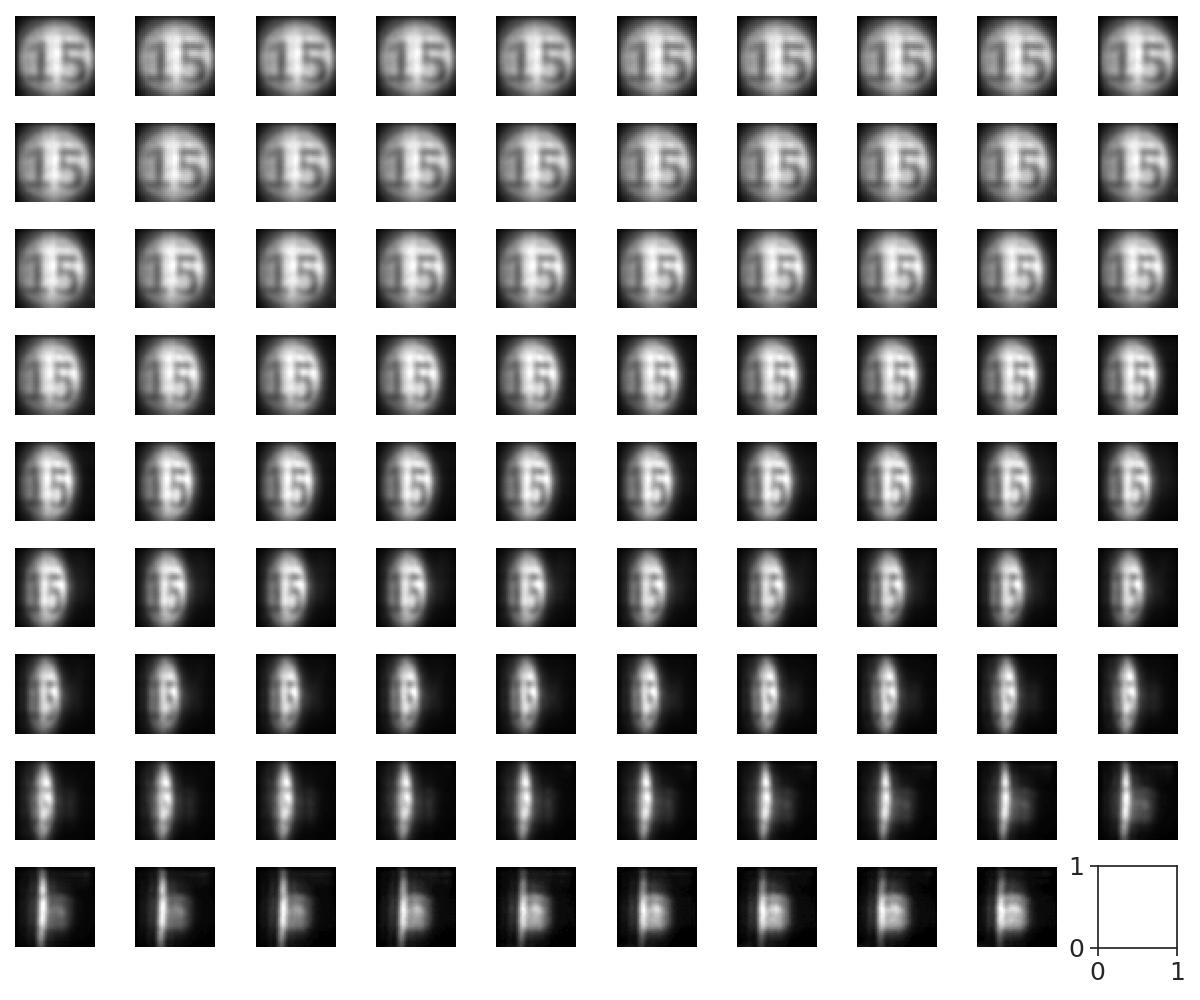

<IPython.core.display.Javascript object>


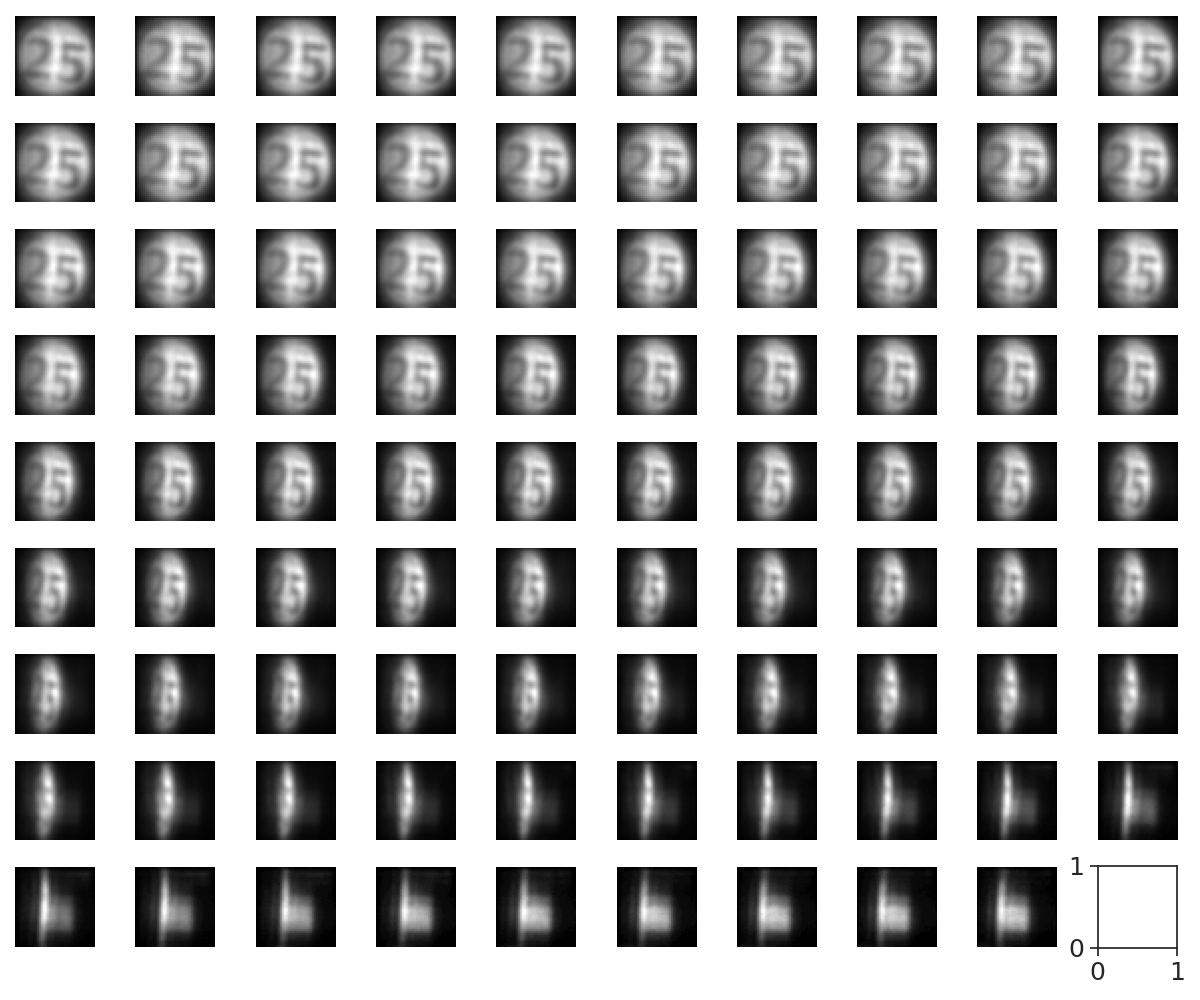

<IPython.core.display.Javascript object>


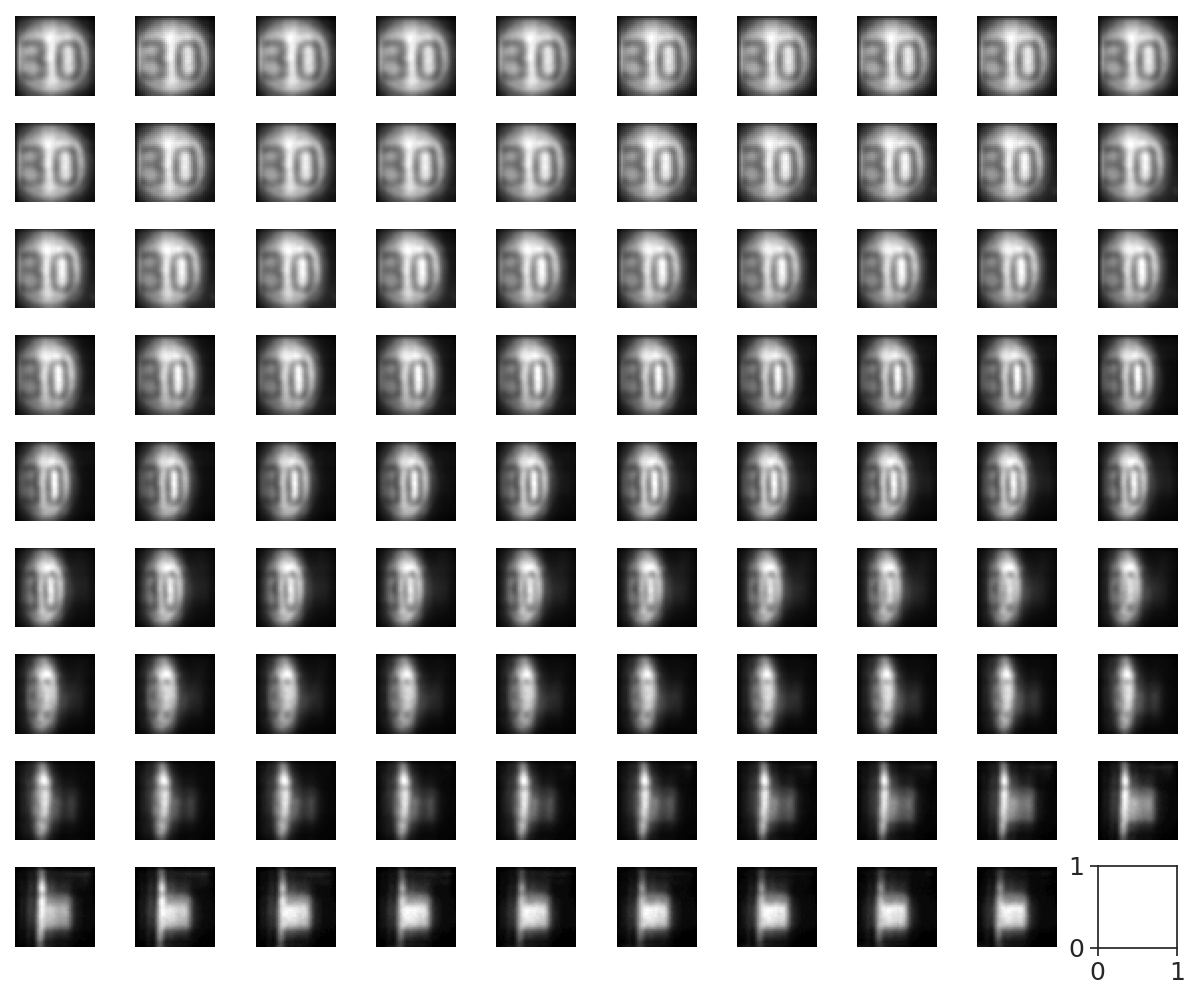

<IPython.core.display.Javascript object>


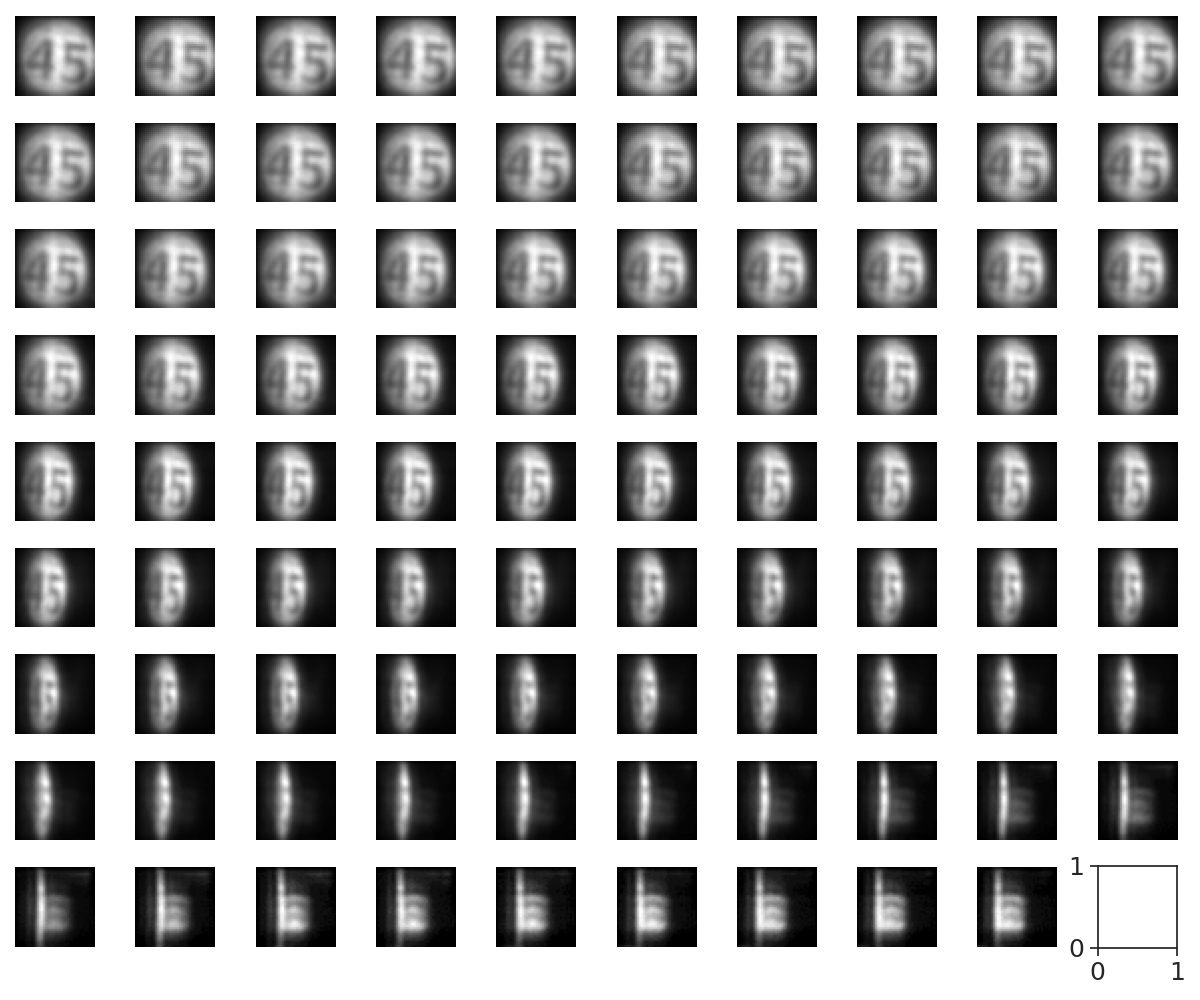

<IPython.core.display.Javascript object>


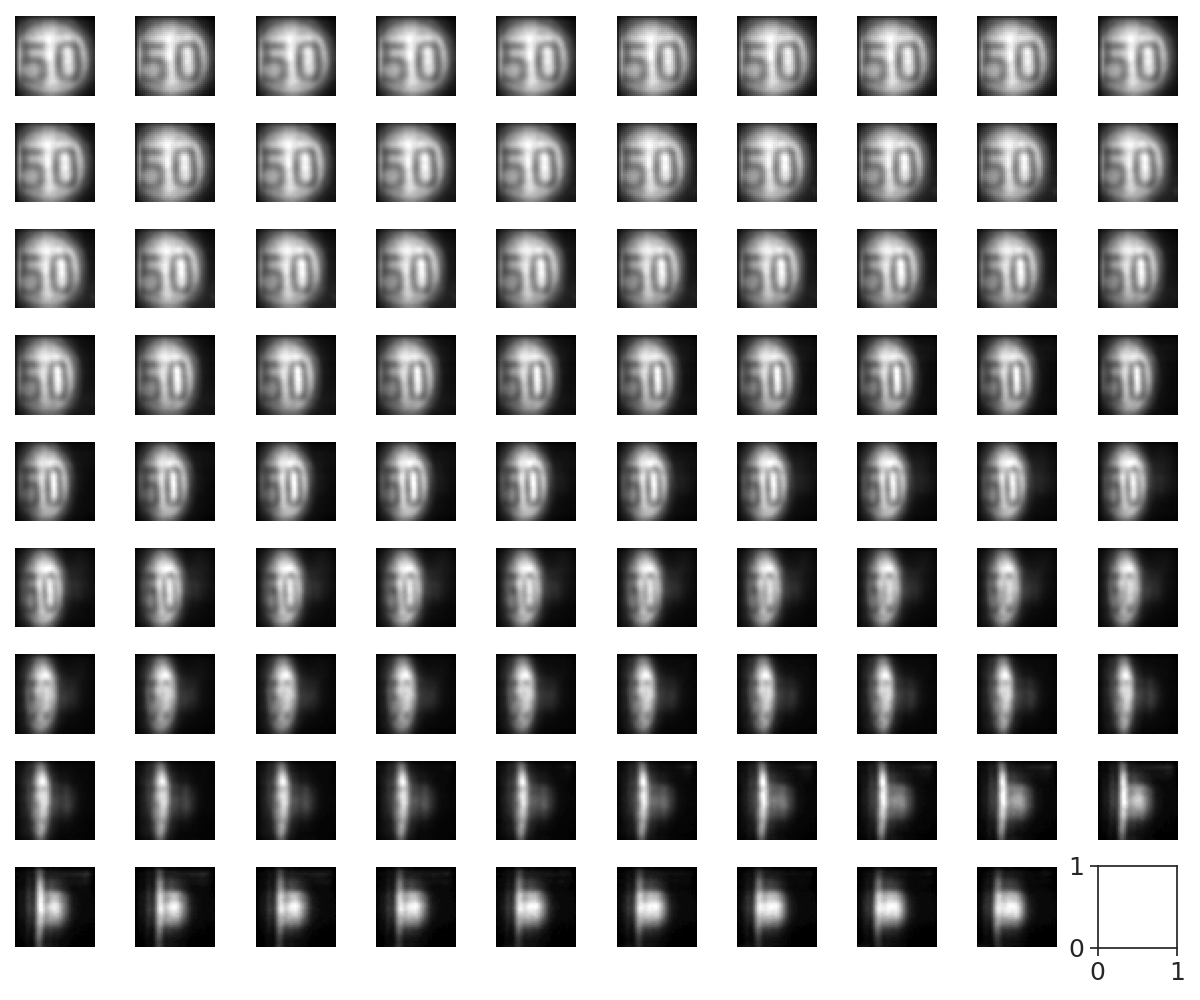

<IPython.core.display.Javascript object>


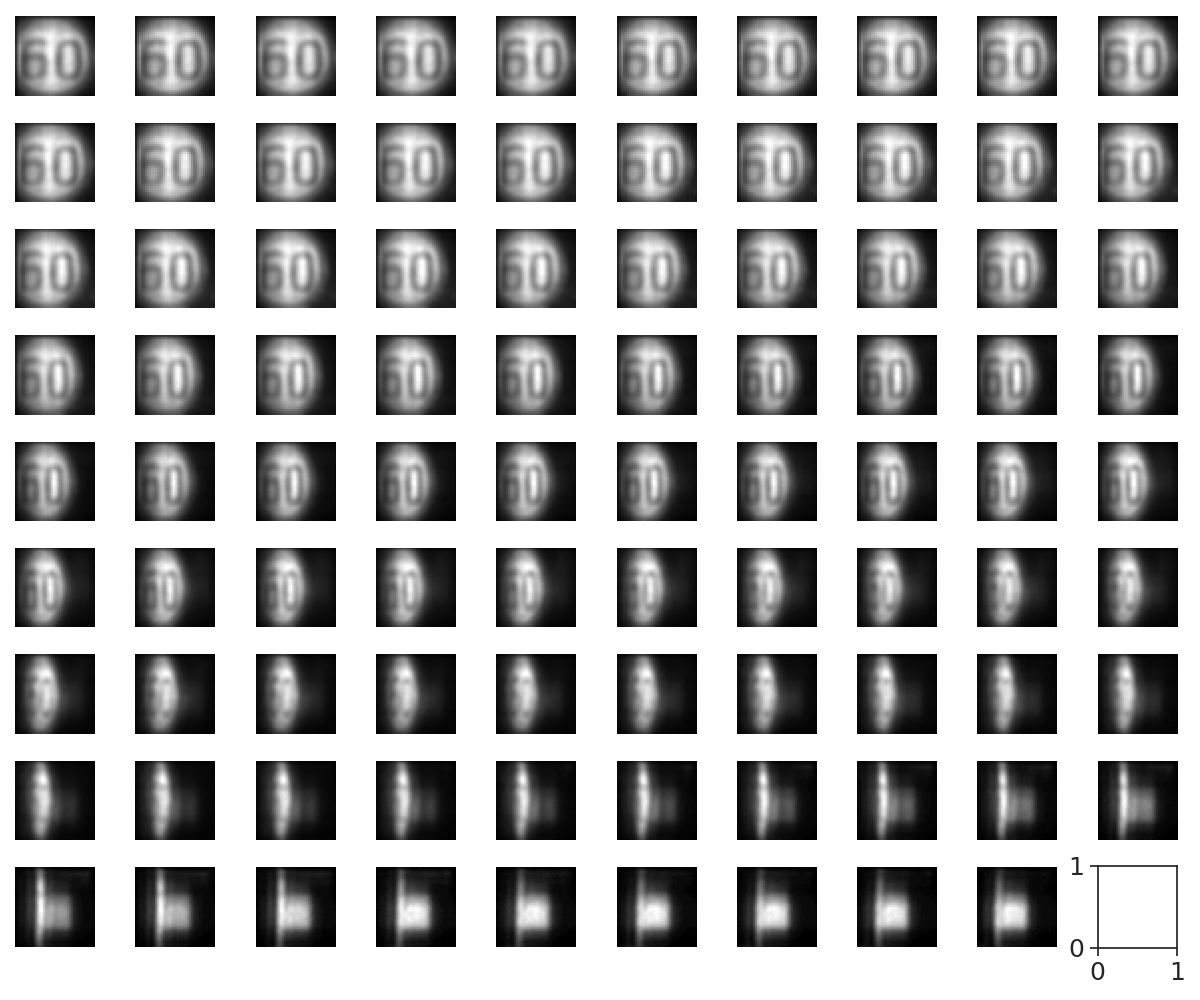

<IPython.core.display.Javascript object>


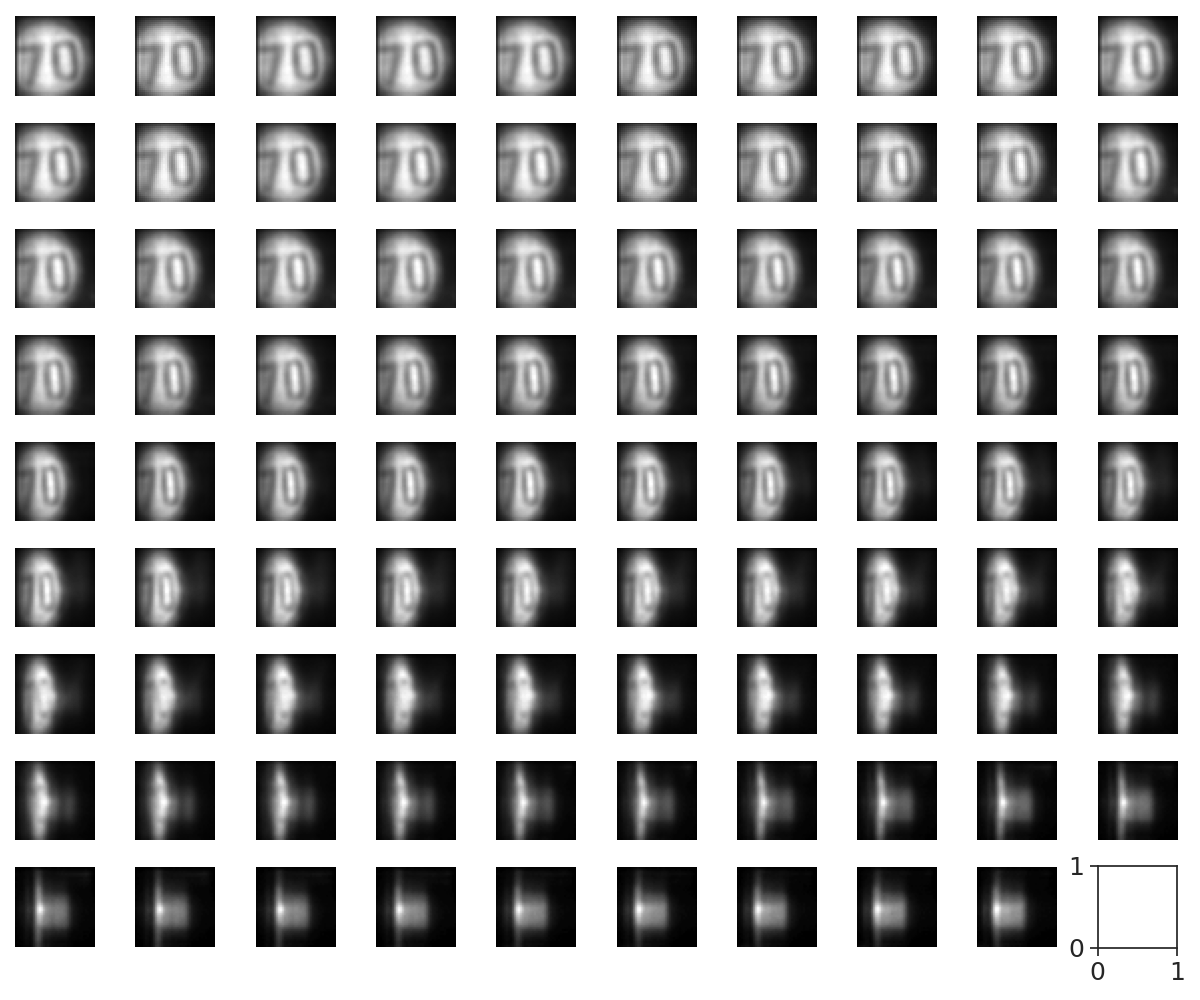

In [607]:
for n in range(7):
    fig, axes = plt.subplots(9,10, figsize=(12,10))

    model.cpu()
#     b = next(enumerate(train_loader_fc2_order))[1]
    imgs = next(enumerate(data_loader_phys_order))[1]
    test_images = imgs[0]
#     correct_labels = b[1]
#     infer_labels = model(imgs[0].to(device="cpu")).argmax(dim=1)
    
    d = {0:15, 1:25, 2:30, 3:45, 4:50, 5:60, 6:70, 7:80}
    P = test_images[range(89*n,89*(n+1)),:].max()
    for idx, k in enumerate(range(89*n,89*(n+1))):
        i = idx//10
        j = idx%10
        ax = axes[i,j]
        ax.imshow(np.fliplr(test_images[k,:].view(40,-1).detach().numpy()/P), cmap='gray')
        ax.axis("off")
#         ax.set_title(f"{d[correct_labels[k].item()]}-->{d[infer_labels[k].item()]}")

    plt.tight_layout()
    plt.show()
    plt.savefig(f"./Figures/Quickdraw_ground_truth_{d[n]}.svg", dpi=300, format="svg")

## nonlinear latent 

In [15]:
model = OpticalClassifier4(36, 2)
model_ckpt = torch.load("./speedlimit_nonlinear_classifier.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

<IPython.core.display.Javascript object>


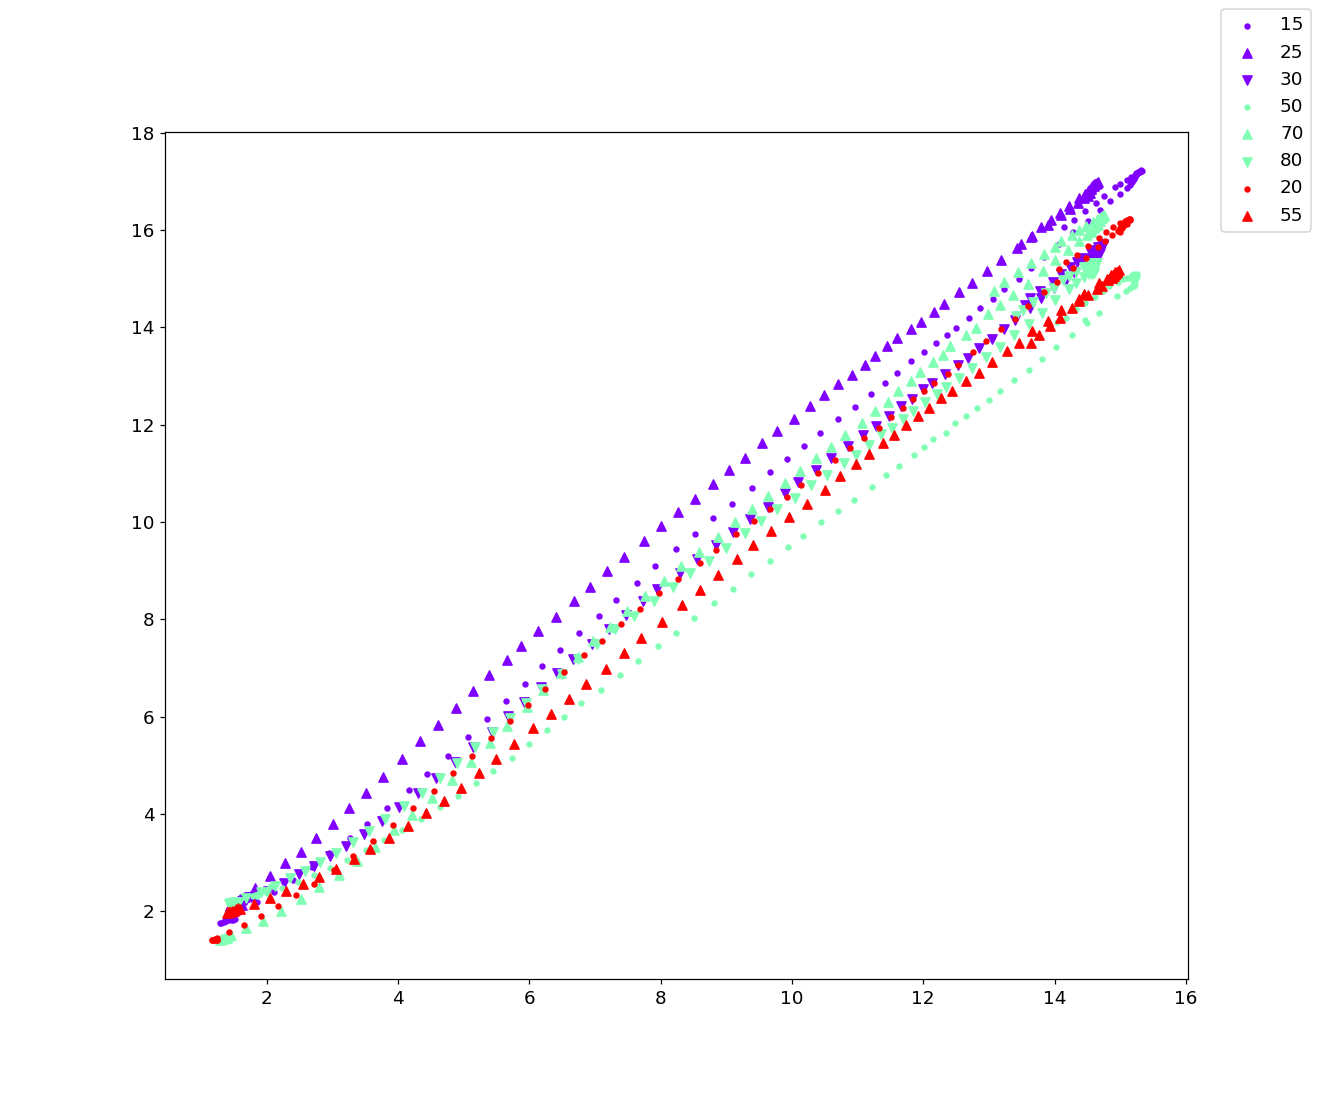

In [16]:
import torchvision
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, ax = plt.subplots(1, 1, figsize=(12,10))

b = next(enumerate(test_loader_fc2_order))[1]
colors = cm.rainbow(np.linspace(0, 1, len(b[1].unique())//3+1))

for ci, i in enumerate(b[1].unique()):
    i = i.item()
    idx = (b[1] == i)
    x = b[0][idx,0]
    y = b[0][idx,1]
    if i == 11:
        y = y +0.2
    if ci%3 == 0:
        ax.scatter(x, y, s=10, label=d[i], color=colors[ci//3,:])
    elif ci%3 == 1:
        ax.scatter(x, y, marker="^", label=d[i], color=colors[ci//3,:])
    elif ci%3 == 2:
        ax.scatter(x, y, marker="v", label=d[i], color=colors[ci//3,:])
    
fig.legend()

<IPython.core.display.Javascript object>


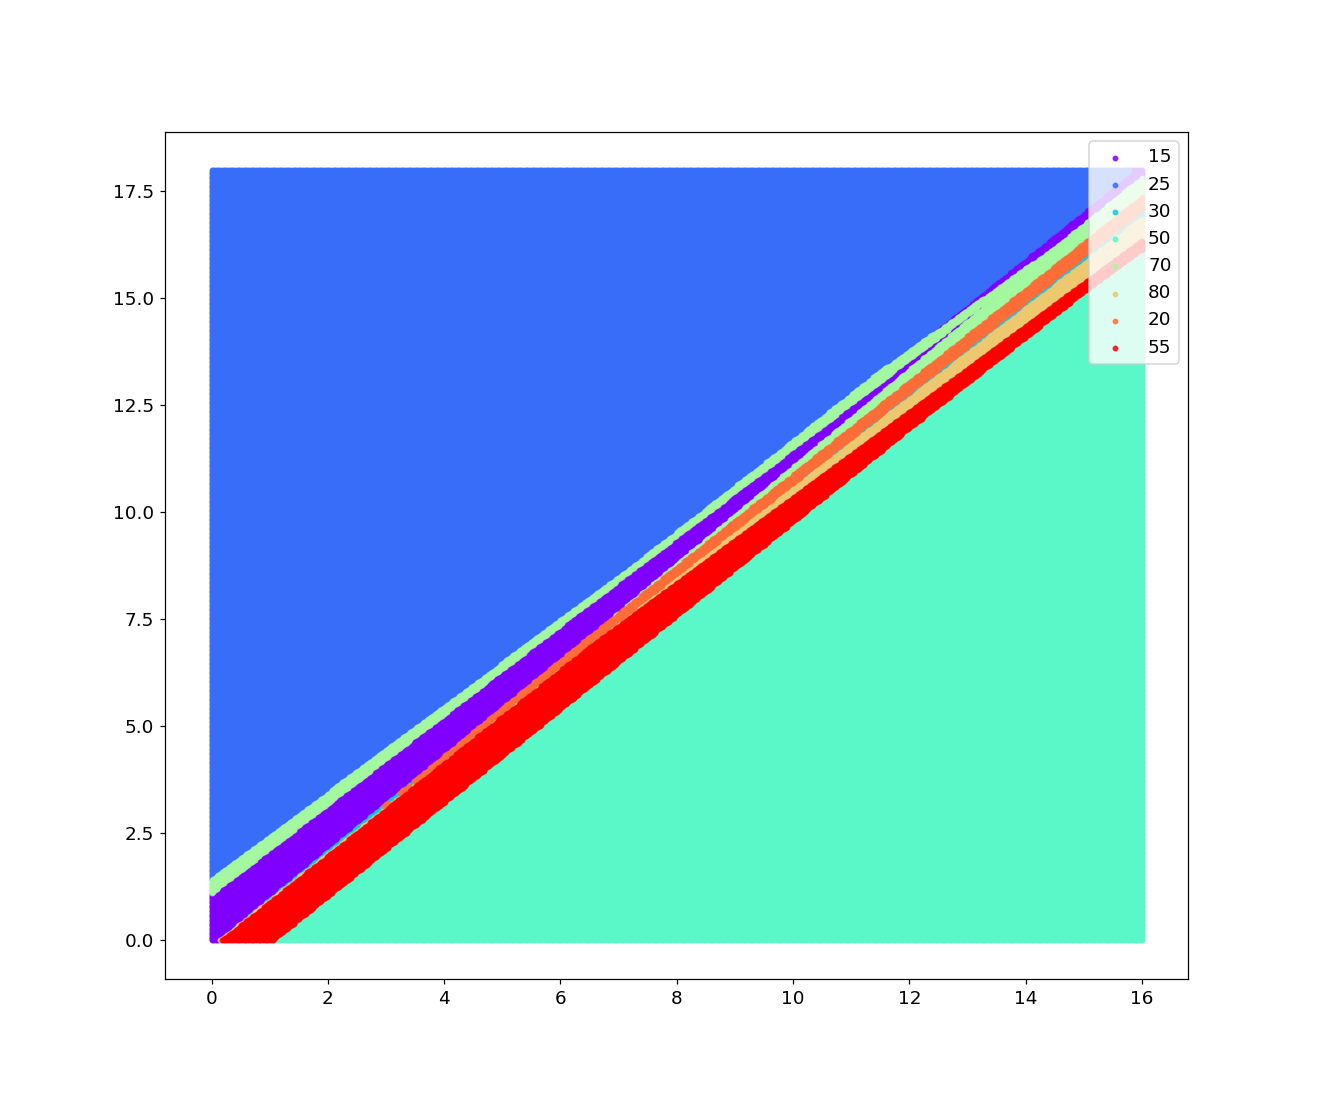

In [17]:
import torchvision
import matplotlib.pyplot as plt

x = np.arange(0,16,0.03)
y = np.arange(0,18,0.03)

xs, ys = np.meshgrid(x, y)
xs, ys = torch.tensor(xs, dtype=torch.float), torch.tensor(ys, dtype=torch.float)
pts = torch.cat((xs.reshape(-1,1), ys.reshape(-1,1)), dim=1)
model.cpu()
outs = model.deco(pts)
lbs = outs.argmax(dim=1).reshape(xs.shape)
fig, ax = plt.subplots(1, 1, figsize=(12,10))
b = next(enumerate(test_loader_fc2_order))[1]
colors = cm.rainbow(np.linspace(0, 1, len(b[1].unique())))
for ci, i in enumerate(b[1].unique()):
    i = i.item()
    idx = (lbs == i)
    ax.scatter(xs[idx], ys[idx], s = 8, alpha=0.8, label = d[i], color=colors[ci,:])
    
plt.legend()



In [18]:
df ={}

In [19]:
import pandas

pandas.set_option('display.max_rows', 100)
pandas.set_option('display.max_columns', 100)
model.cpu()
b = next(enumerate(test_loader_fc2_order))[1]
correct_labels = b[1]
infer_labels = model(b[0].to(device="cpu")).argmax(dim=1)
dtmp = {}
for k, v in d.items():
    idx = (correct_labels == k)
    dtmp[v] = infer_labels[idx].apply_(lambda x:d[x])
    print(dtmp[v].shape)

df['nl'] = pandas.DataFrame(dtmp).T
df['nl'] = df['nl'].sort_index()
df['nl']

torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])


0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15   
20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20   
25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25   
30  20  20  20  20  20  20  20  20  20  20  20  30  30  30  30  30  30  30   
50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50   
55  50  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
70  70  70  70  70  70  70  70  70  70  70  70  70  70  70  70  70  70  70   
80  30  30  30  30  30  30  30  30  80  80  80  80  80  80  80  80  80  80   

    18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  \
15  15  15  15  15  15  15  15  15  15  15  15  15  70  15  15  15  15  15   
20  20  20  20  20  30  20  20  20  20  30  30  30  30  30  30  30  30  30   
25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25   
30  30  30  30  30  30  30  30  30  30  30  30  30  30  30  30  30  30  30   
50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50   
55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
70  70  70  70  70  70  70  70  70  70  70  70  70  70  70  70  70  70  70   
80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80   

    36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  \
15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15   
20  30  30  30  30  30  80  30  80  30  30  30  30  30  30  30  30  30  30   
25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25   
30  30  30  30  30  30  30  30  30  30  30  30  30  30  20  20  20  20  20   
50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50   
55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
70  70  70  70  70  70  70  70  70  70  70  70  70  70  70  70  70  70  70   
80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80   

    54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  \
15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  20   
20  30  30  20  20  20  30  30  30  80  55  55  55  55  55  55  55  55  55   
25  25  25  25  25  25  25  25  25  25  25  25  70  70  15  15  15  15  15   
30  20  20  20  20  20  20  20  20  20  20  30  30  30  80  55  55  55  55   
50  50  50  50  50  50  50  50  50  55  55  55  55  55  55  55  55  55  55   
55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55   
70  70  70  70  70  70  70  70  20  20  20  30  80  55  55  55  55  55  55   
80  30  30  30  30  30  30  30  30  30  80  80  55  55  55  55  55  55  55   

    72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  
15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  
20  55  55  55  55  55  80  15  15  15  15  15  15  15  15  15  15  15  
25  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  
30  55  55  80  30  30  15  15  15  15  15  15  15  15  15  15  15  15  
50  55  55  55  55  55  80  15  15  15  15  15  15  15  15  15  15  15  
55  55  55  55  55  55  15  15  15  15  15  15  15  15  15  15  15  15  
70  55  55  55  55  55  55  55  55  55  80  15  15  15  15  15  15  15  
80  55  80  30  15  15  15  15  15  15  15  15  15  15  15  15  15  15

In [27]:
df['nl_correc'] = pandas.DataFrame().reindex_like(df['nl'])

for index, row in df['nl_correc'].iterrows():
    df['nl_correc'].loc[index,:] = ((df['nl'].loc[index,:] == index).astype(int))
    
df['nl_correc'].loc['sum',:] = df['nl_correc'].sum(axis=0)
df['nl_correc'] = df['nl_correc'].astype('int32')
display(df['nl_correc'])
print(df['nl_correc'].loc['sum',:].sum()/len(b[1]))

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
15    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
20    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
25    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
30    0   0   0   0   0   0   0   0   0   0   0   1   1   1   1   1   1   1   
50    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
55    0   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
70    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
80    0   0   0   0   0   0   0   0   1   1   1   1   1   1   1   1   1   1   
sum   5   6   6   6   6   6   6   6   7   7   7   8   8   8   8   8   8   8   

     18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  \
15    1   1   1   1   1   1   1   1   1   1   1   1   0   1   1   1   1   1   
20    1   1   1   1   0   1   1   1   1   0   0   0   0   0   0   0   0   0   
25    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
30    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
50    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
55    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
70    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
80    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
sum   8   8   8   8   7   8   8   8   8   7   7   7   6   7   7   7   7   7   

     36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  \
15    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
20    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
25    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
30    1   1   1   1   1   1   1   1   1   1   1   1   1   0   0   0   0   0   
50    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
55    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
70    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
80    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
sum   7   7   7   7   7   7   7   7   7   7   7   7   7   6   6   6   6   6   

     54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  \
15    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   0   
20    0   0   1   1   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
25    1   1   1   1   1   1   1   1   1   1   1   0   0   0   0   0   0   0   
30    0   0   0   0   0   0   0   0   0   0   1   1   1   0   0   0   0   0   
50    1   1   1   1   1   1   1   1   0   0   0   0   0   0   0   0   0   0   
55    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
70    1   1   1   1   1   1   1   0   0   0   0   0   0   0   0   0   0   0   
80    0   0   0   0   0   0   0   0   0   1   1   0   0   0   0   0   0   0   
sum   5   5   6   6   6   5   5   4   3   4   5   3   3   2   2   2   2   1   

     72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  
15    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1  
20    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  
25    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  
30    0   0   0   1   1   0   0   0   0   0   0   0   0   0   0   0   0  
50    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  
55    1   1   1   1   1   0   0   0   0   0   0   0   0   0   0   0   0  
70    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  
80    0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  
sum   2   3   2   3   3   1   1   1   1   1   1   1   1   1   1   1   1

0.6629213483146067


## linear latent 

In [28]:
model = OpticalClassifier_L3(2)
model_ckpt = torch.load("./speedlimit_linear_classifier.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

<IPython.core.display.Javascript object>


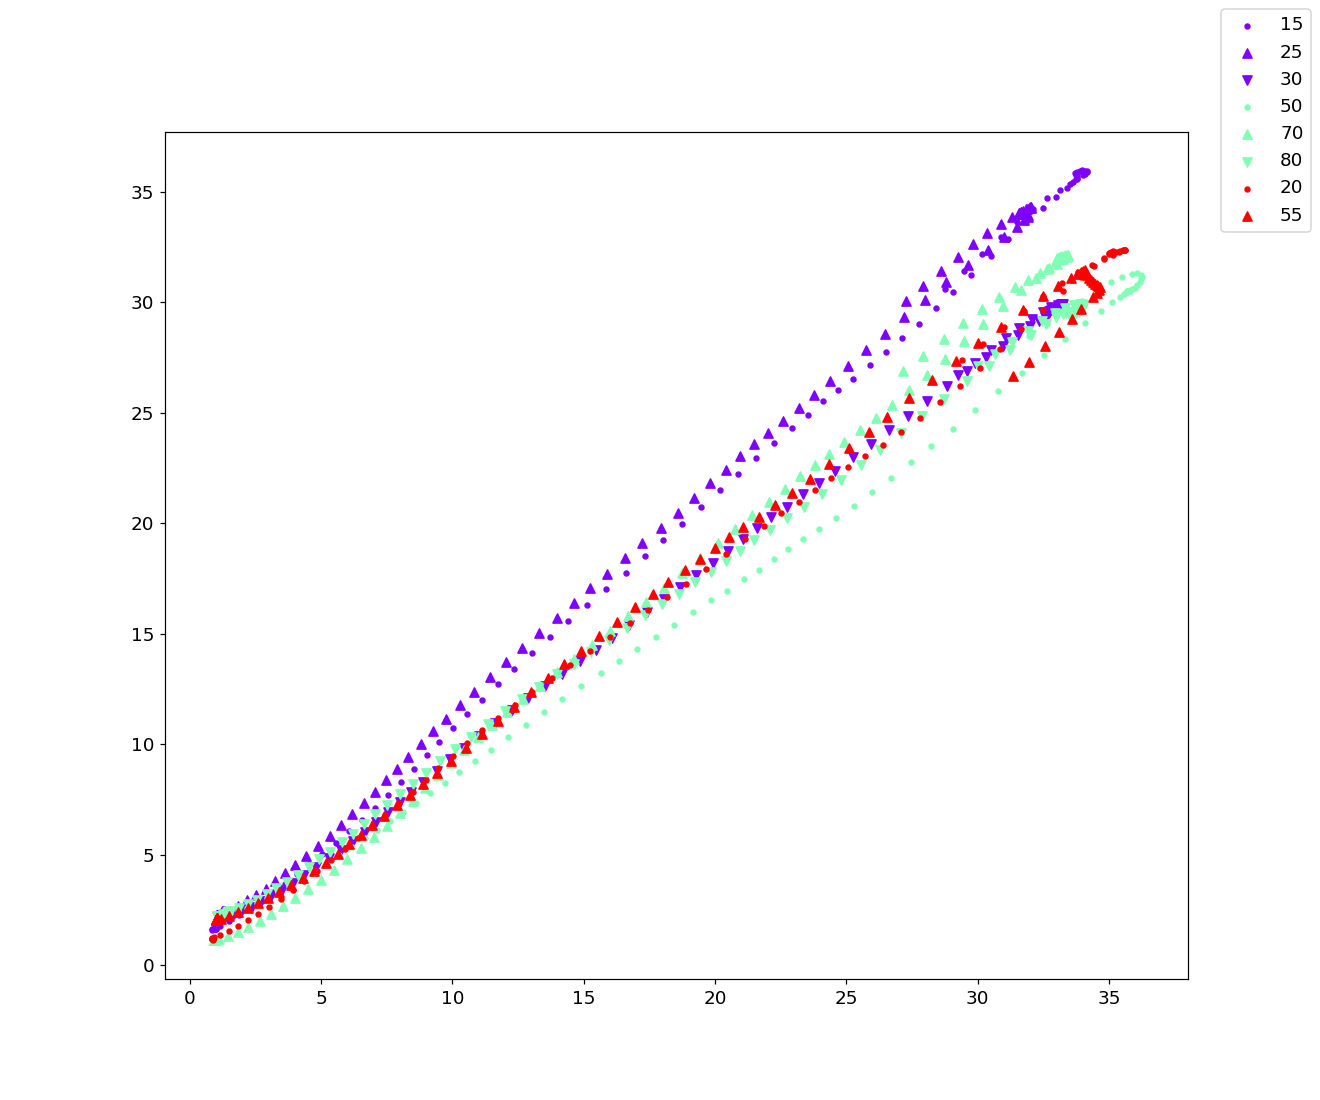

In [29]:
import torchvision
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, ax = plt.subplots(1, 1, figsize=(12,10))

b = next(enumerate(test_lin_loader_fc1_order))[1]
colors = cm.rainbow(np.linspace(0, 1, len(b[1].unique())//3+1))

for ci, i in enumerate(b[1].unique()):
    i = i.item()
    idx = (b[1] == i)
    if ci%3 == 0:
        ax.scatter(b[0][idx,0], b[0][idx,1], s=10, label=d[i], color=colors[ci//3,:])
    elif ci%3 == 1:
        ax.scatter(b[0][idx,0], b[0][idx,1], marker="^", label=d[i], color=colors[ci//3,:])
    elif ci%3 == 2:
        ax.scatter(b[0][idx,0], b[0][idx,1], marker="v", label=d[i], color=colors[ci//3,:])
    
fig.legend()

<IPython.core.display.Javascript object>


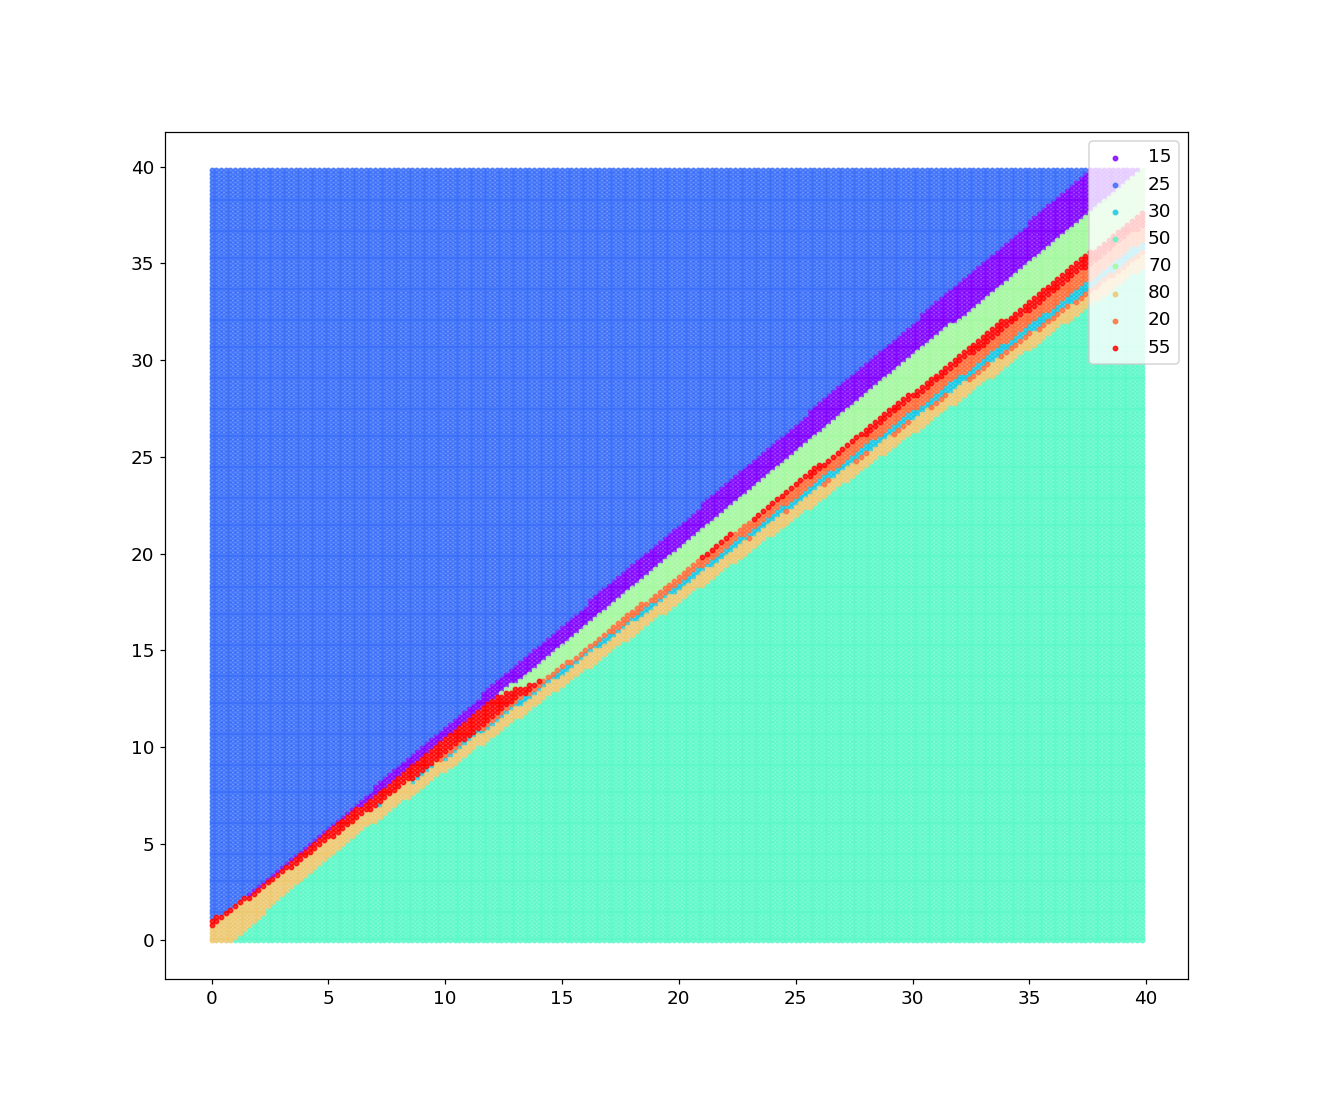

In [30]:
x = np.arange(0,40,0.2)
y = np.arange(0,40,0.2)
xs, ys = np.meshgrid(x, y)
xs, ys = torch.tensor(xs, dtype=torch.float), torch.tensor(ys, dtype=torch.float)
pts = torch.cat((xs.reshape(-1,1), ys.reshape(-1,1)), dim=1)
model.cpu()
outs = model.deco(pts)
lbs = outs.argmax(dim=1).reshape(xs.shape)
fig, ax = plt.subplots(1, 1, figsize=(12,10))
b = next(enumerate(test_lin_loader_fc1_order))[1]
colors = cm.rainbow(np.linspace(0, 1, len(b[1].unique())))
for ci, i in enumerate(b[1].unique()):
    i = i.item()
    idx = (lbs == i)
    ax.scatter(xs[idx], ys[idx], s = 8, alpha=0.8, label = d[i], color=colors[ci,:])
    
plt.legend()


In [31]:
import pandas

pandas.set_option('display.max_rows', 100)
pandas.set_option('display.max_columns', 100)
model.cpu()
b = next(enumerate(test_lin_loader_fc1_order))[1]
correct_labels = b[1]
infer_labels = model(b[0].to(device="cpu")).argmax(dim=1)
dtmp = {}
for k, v in d.items():
    idx = (correct_labels == k)
    dtmp[v] = infer_labels[idx].apply_(lambda x:d[x])

df['l'] = pandas.DataFrame(dtmp).T
df['l'] = df['l'].sort_index()
df['l']

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
15  15  15  25  25  25  25  15  15  15  15  15  15  15  15  15  15  15  15   
20  20  20  20  20  20  20  20  20  20  20  20  30  30  30  20  20  20  20   
25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25   
30  30  30  30  30  20  30  30  30  30  30  30  30  30  30  30  30  30  30   
50  80  80  80  80  80  80  80  50  50  50  50  50  50  50  50  50  50  50   
55  50  50  50  50  50  80  80  80  80  80  80  80  20  30  30  30  20  20   
70  70  70  70  70  70  70  70  70  70  70  70  70  70  70  70  70  70  70   
80  30  30  30  30  20  20  80  80  80  80  80  80  80  80  80  80  80  80   

    18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  \
15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15   
20  20  20  20  20  20  20  20  20  20  20  20  20  30  30  20  80  80  80   
25  25  25  25  25  15  15  15  15  15  25  25  25  25  25  25  25  25  25   
30  30  30  30  30  30  30  30  30  30  30  30  30  30  30  30  30  30  30   
50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50   
55  20  20  20  20  20  20  55  55  55  55  55  55  55  20  20  20  20  20   
70  70  70  70  70  70  70  70  70  70  70  70  70  70  70  70  70  70  70   
80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80   

    36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  \
15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15   
20  80  80  80  80  80  20  20  30  30  30  30  30  30  30  30  30  30  30   
25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25   
30  30  30  30  30  30  30  30  30  30  30  30  30  30  30  30  30  30  30   
50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50   
55  20  20  20  20  55  55  70  70  70  70  70  70  70  70  70  20  20  20   
70  70  70  70  70  70  70  70  70  70  70  70  70  70  70  20  70  70  20   
80  80  80  80  80  80  80  80  80  80  80  30  30  30  30  30  20  20  20   

    54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  \
15  15  15  15  15  15  15  15  15  15  55  55  55  55  55  55  80  80  80   
20  20  20  20  20  20  20  30  30  80  80  80  80  80  80  80  80  80  80   
25  25  25  25  25  25  25  25  25  25  15  15  15  15  15  55  55  55  55   
30  30  30  30  30  30  30  80  80  80  80  80  80  80  80  80  80  80  80   
50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  80  80  80   
55  30  30  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80   
70  20  20  20  20  20  30  30  80  80  80  80  50  50  50  50  50  50  50   
80  20  20  55  55  20  80  80  30  30  80  80  80  80  80  80  80  80  80   

    72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  
15  80  80  80  80  80  80  80  80  80  55  55  55  55  55  80  80  80  
20  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  
25  55  55  55  55  55  15  15  25  25  25  25  25  25  25  25  25  25  
30  80  80  80  80  80  80  55  15  25  25  25  25  25  25  25  25  25  
50  80  80  80  80  80  55  15  25  25  25  25  25  25  25  25  25  25  
55  80  80  80  80  55  25  25  25  25  25  25  25  25  25  25  25  25  
70  50  50  50  50  50  80  80  80  80  80  80  80  80  80  80  80  80  
80  80  80  80  55  55  15  25  25  25  25  25  25  25  25  25  25  25

In [32]:
df['l_correc'] = pandas.DataFrame().reindex_like(df['nl'])

for index, row in df['l_correc'].iterrows():
    df['l_correc'].loc[index,:] = ((df['l'].loc[index,:] == index).astype(int))
    
df['l_correc'].loc['sum',:] = df['l_correc'].sum(axis=0)
df['l_correc'] =df['l_correc'].astype('int32')
display(df['l_correc'])
print(df['l_correc'].loc['sum',:].sum()/len(b[1]))

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
15    1   1   0   0   0   0   1   1   1   1   1   1   1   1   1   1   1   1   
20    1   1   1   1   1   1   1   1   1   1   1   0   0   0   1   1   1   1   
25    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
30    1   1   1   1   0   1   1   1   1   1   1   1   1   1   1   1   1   1   
50    0   0   0   0   0   0   0   1   1   1   1   1   1   1   1   1   1   1   
55    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
70    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
80    0   0   0   0   0   0   1   1   1   1   1   1   1   1   1   1   1   1   
sum   5   5   4   4   3   4   6   7   7   7   7   6   6   6   7   7   7   7   

     18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  \
15    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
20    1   1   1   1   1   1   1   1   1   1   1   1   0   0   1   0   0   0   
25    1   1   1   1   0   0   0   0   0   1   1   1   1   1   1   1   1   1   
30    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
50    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
55    0   0   0   0   0   0   1   1   1   1   1   1   1   0   0   0   0   0   
70    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
80    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
sum   7   7   7   7   6   6   7   7   7   8   8   8   7   6   7   6   6   6   

     36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  \
15    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
20    0   0   0   0   0   1   1   0   0   0   0   0   0   0   0   0   0   0   
25    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
30    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
50    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
55    0   0   0   0   1   1   0   0   0   0   0   0   0   0   0   0   0   0   
70    1   1   1   1   1   1   1   1   1   1   1   1   1   1   0   1   1   0   
80    1   1   1   1   1   1   1   1   1   1   0   0   0   0   0   0   0   0   
sum   6   6   6   6   7   8   7   6   6   6   5   5   5   5   4   5   5   4   

     54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  \
15    1   1   1   1   1   1   1   1   1   0   0   0   0   0   0   0   0   0   
20    1   1   1   1   1   1   0   0   0   0   0   0   0   0   0   0   0   0   
25    1   1   1   1   1   1   1   1   1   0   0   0   0   0   0   0   0   0   
30    1   1   1   1   1   1   0   0   0   0   0   0   0   0   0   0   0   0   
50    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   0   0   0   
55    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
70    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
80    0   0   0   0   0   1   1   0   0   1   1   1   1   1   1   1   1   1   
sum   5   5   5   5   5   6   4   3   3   2   2   2   2   2   2   1   1   1   

     72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  
15    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  
20    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  
25    0   0   0   0   0   0   0   1   1   1   1   1   1   1   1   1   1  
30    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  
50    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  
55    0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0  
70    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  
80    1   1   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0  
sum   1   1   1   0   1   0   0   1   1   1   1   1   1   1   1   1   1

0.5617977528089888


## Angular dependence 

In [33]:
SMALL_SIZE = 10
MEDIUM_SIZE = 18
BIGGER_SIZE = 16

plt.rcParams["font.family"] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
np.random.seed(3)

<IPython.core.display.Javascript object>


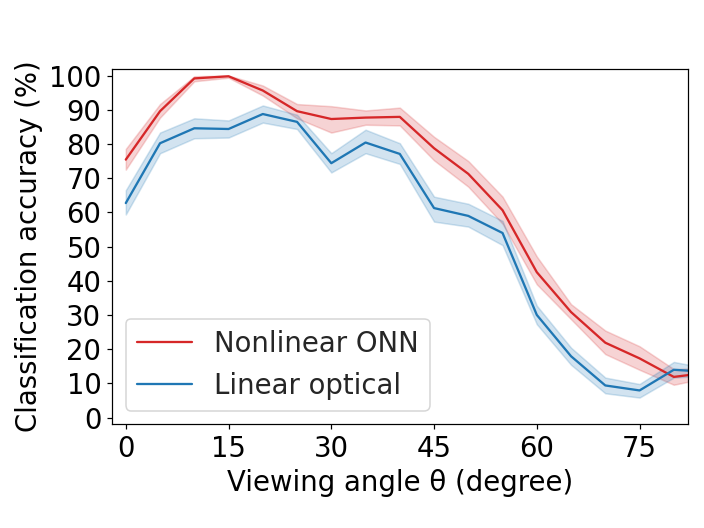

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


In [34]:
import seaborn as sns

fig, ax = plt.subplots(1,1)

cmap = plt.get_cmap("tab10")
sns.set_style("ticks")
ang_int = range(0,10)
n_secs = len(angle_range)//len(ang_int)
win_len = 10
n_trials = 20
major_angs = np.arange(0,90,5)
n_samples = int(len(ang_int)*df['nl'].shape[0]*0.3)
correc_perc = {}
correc_perc['nl'] = np.zeros((n_trials, len(major_angs)))
correc_perc['l'] = np.zeros(correc_perc['nl'] .shape)
for i, s in enumerate(major_angs):
    angs = range(s, min(s+win_len, angle_range[-1]+1))
    for t in range(n_trials):
        arr_nl = df['nl_correc'].iloc[:-1,angs].to_numpy().flatten()
        correc_perc['nl'][t,i] = np.random.choice(arr_nl, n_samples, replace=False).sum()/n_samples
        arr_l = df['l_correc'].iloc[:-1,angs].to_numpy().flatten()
        correc_perc['l'][t,i] = np.random.choice(arr_l, n_samples, replace=False).sum()/n_samples

df1 = pandas.DataFrame(data=[np.repeat(major_angs, n_trials), correc_perc['nl'].T.flatten()*100], index=["angle", "perc"])
sns.lineplot(data = df1.T, x="angle", y="perc", color=cmap(3), label="Nonlinear ONN")

df2 = pandas.DataFrame(data=[np.repeat(major_angs, n_trials), correc_perc['l'].T.flatten()*100], index=["angle", "perc"])
sns.lineplot(data = df2.T, x="angle", y="perc", color=cmap(0), label="Linear optical")

# ax.errorbar(df['nl_correc'].columns[5::10], correc_perc['nl'].mean(axis=0)*100, yerr=correc_perc['nl'].std(axis=0)*100, marker='v', c=cmap(0), capsize=2, label="Nonlinear 2-layer optical encoder")
# ax.errorbar(df['l_correc'].columns[5::10], correc_perc['l'].mean(axis=0)*100, yerr=correc_perc['l'].std(axis=0)*100, marker='^', c=cmap(3), capsize=2, label="Linear 1-layer optical encoder")
ax.set_ylim(-2,102)
ax.set_xlim(-2, 82)
ax.set_yticks(list(range(0,101,10)))
ax.set_xticks(list(range(0,80,15)))
ax.set_ylabel("Classification accuracy (%)", fontsize=18)
ax.set_xlabel("Viewing angle θ (degree)", fontsize=18)
plt.legend()

ratio = 1/1.618
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

plt.tight_layout()
plt.show()
# plt.savefig(f"./Figures/accu_vs_angle.svg", dpi=300, format="svg")

## Confusion matrices 

<IPython.core.display.Javascript object>


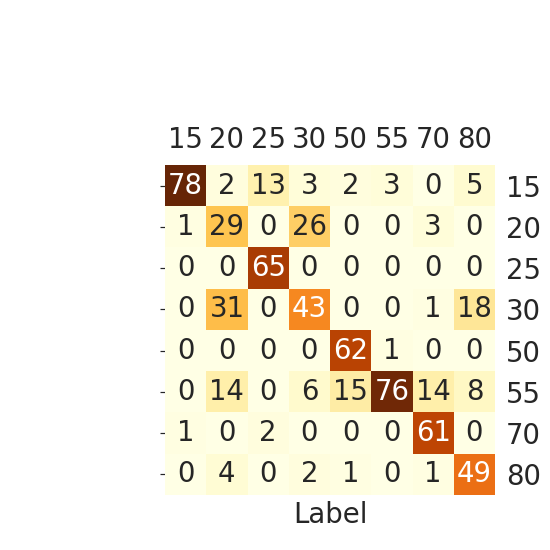

In [35]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas

conMat = {}
speeds = [15, 20, 25, 30, 50, 55, 70, 80]
for v1 in speeds:    
    conMat[v1] = [(df['nl'].loc[v1,0:79] == v2).sum().item() for v2 in speeds]
dfcl = pandas.DataFrame(conMat)
dfcl = dfcl.rename(index=dict(zip(dfcl.index, dfcl.columns)))

dfcl.columns.name = 'Label'
fig, ax = plt.subplots(1,1, figsize = (5,5))
ax.set_position([0.3,0.1,0.6,0.6])
sns.set(font_scale=1.5)#for label size
#df[df==0] = np.nanb
sns.heatmap(dfcl, cmap="YlOrBr", annot=True, annot_kws={"size": 18}, cbar=False)# font size
ax.tick_params(axis='x', rotation=0, labelbottom=False, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='y', rotation=0, labelleft=False, labelright=True)
ax.yaxis.set_label_position("left")

# plt.tick_params(axis='both', which='major', labelsize=10, , )
plt.savefig(f"./speedlimit_nonlinear_confusion_matrix.svg", dpi=300, format="svg")

<IPython.core.display.Javascript object>


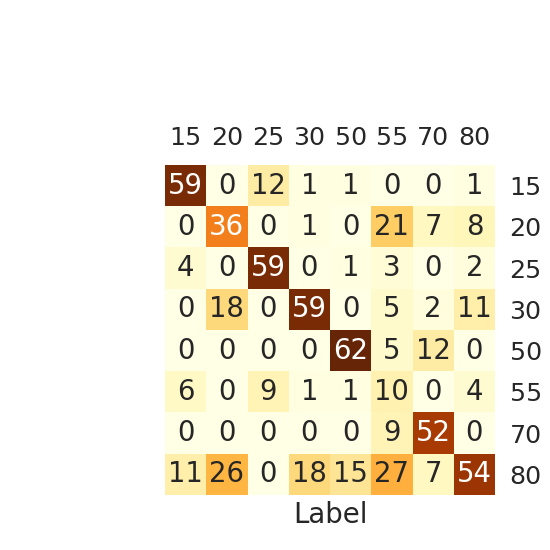

In [36]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas

conMat = {}
for v1 in speeds:    
    conMat[v1] = [(df['l'].loc[v1,0:79] == v2).sum().item() for v2 in speeds]
dfcl = pandas.DataFrame(conMat)
dfcl = dfcl.rename(index=dict(zip(dfcl.index, dfcl.columns)))

dfcl.columns.name = 'Label'
fig, ax = plt.subplots(1,1, figsize = (5,5))
ax.set_position([0.3,0.1,0.6,0.6])
sns.set(font_scale=1.5)#for label size
#df[df==0] = np.nanb
sns.heatmap(dfcl, cmap="YlOrBr", annot=True, annot_kws={"size": 18}, cbar=False)# font size
ax.tick_params(axis='x', rotation=0, labelbottom=False, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='y', rotation=0, labelleft=False, labelright=True)
ax.yaxis.set_label_position("left")

# plt.tick_params(axis='both', which='major', labelsize=10, , )
# plt.savefig(f"./Speedlimit_linear_confusion_matrix.svg", dpi=300, format="svg")

## Nonlinear curves

<IPython.core.display.Javascript object>


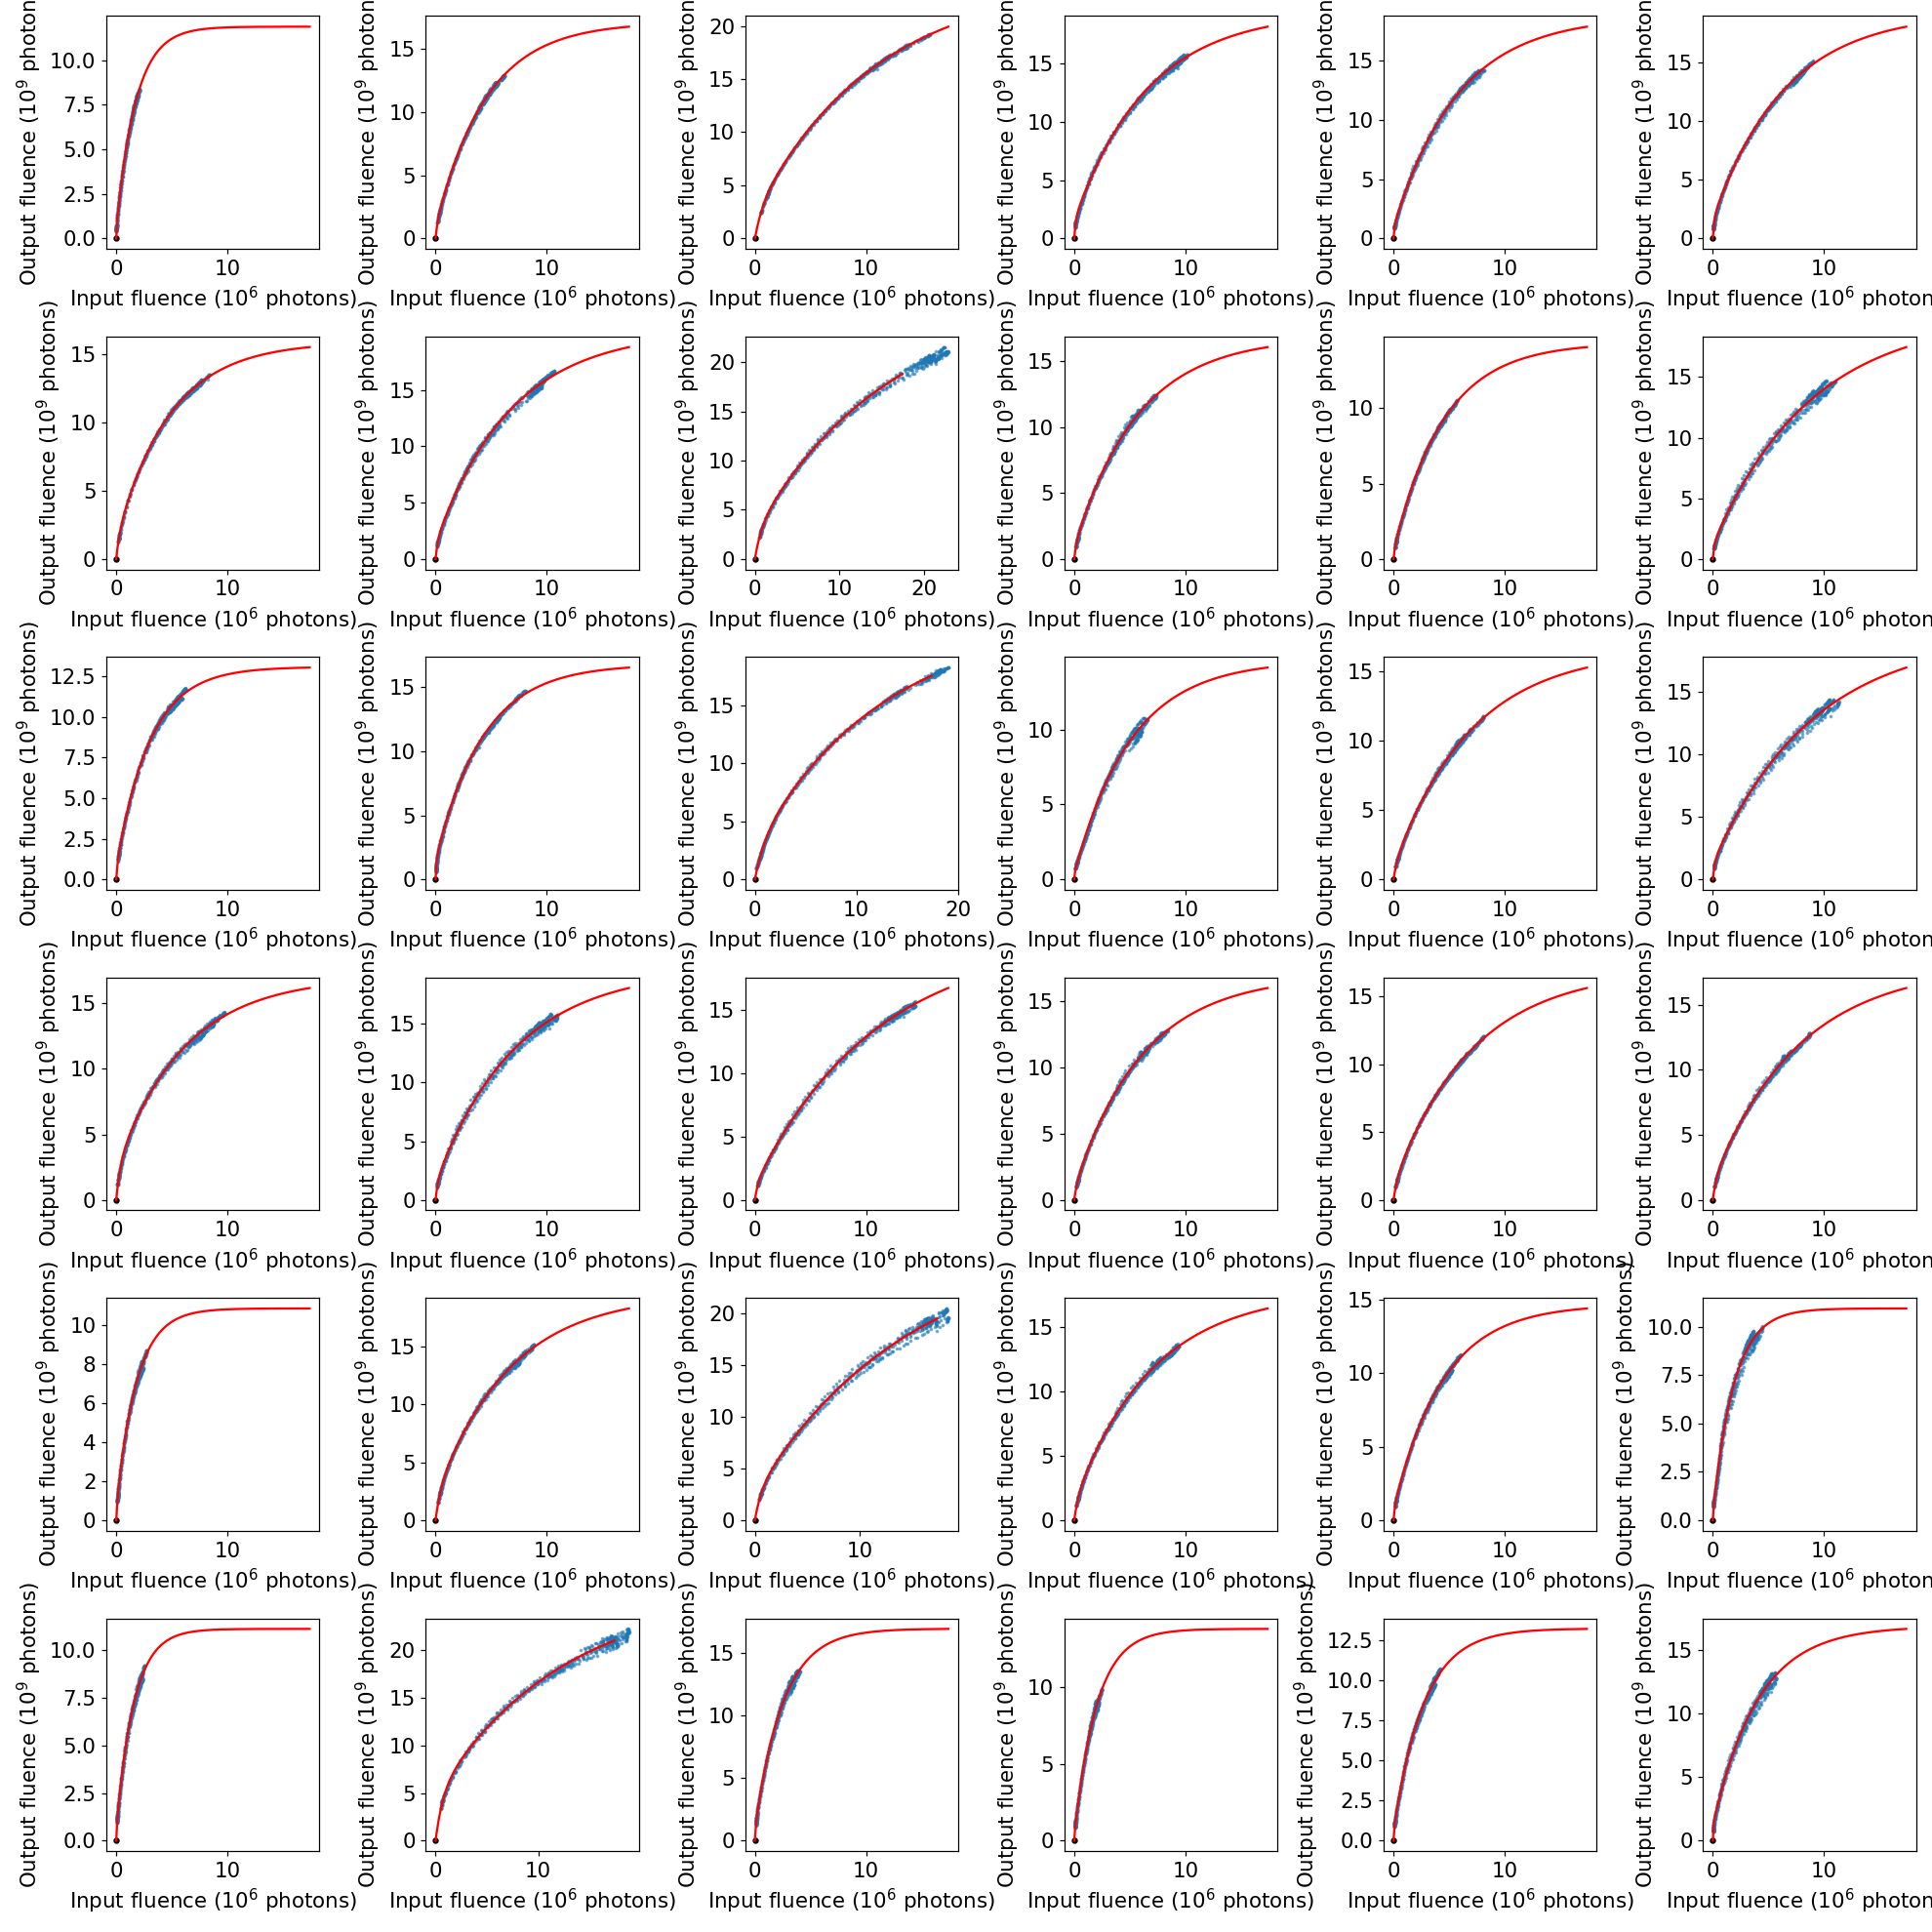

[ 0.58101007 93.12115053 11.30212288  0.56355201]
[16.18208282  0.21934145  0.93150253  6.33035906]


/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


[22.06294442  0.09076873  2.41181361  1.50734755]
[ 1.52982179  7.56088976 17.90622959  0.15147686]
[ 0.96026814 12.60703629 17.80567019  0.17270637]
[17.57057513  0.15403595  1.64555746  7.76416798]


/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.


[14.52484748  0.20824622  1.40736248  3.69683704]
[18.85029346  0.14664998  1.43141877  5.01700563]
[ 2.71320417  1.35936648 24.35802627  0.0622305 ]
[ 0.89606073  5.16481677 15.93978966  0.17388989]
[13.82223732  0.22115756  0.53770238  9.57479591]
[ 1.18495479  6.78752194 18.91743092  0.11321536]
[12.28768017  0.32862737  0.7775846   8.9364219 ]
[15.33159218  0.2349875   1.43673372 13.37604013]
[ 2.60040767  1.12924396 19.92835673  0.07936238]
[ 14.23611951   0.1943999    0.38472958 110.34651437]
[15.67147305  0.1430747   0.86656144  3.51158644]
[ 1.28446134  5.96067645 18.27611264  0.11096748]
[ 2.44092402  2.82255881 14.58377915  0.16320099]
[ 1.43208545  4.77622439 18.25017776  0.13939302]
[ 1.13866864  3.5222038  19.58672439  0.09183752]
[16.11645114  0.16110157  0.87609466  3.85075849]
[ 1.15536782  2.90808563 15.84984793  0.14006921]
[ 1.4023828   3.25611741 16.66049113  0.12852482]
[10.14903997  0.53894815  0.72259838  8.6645321 ]
[ 2.03860443  2.43235189 17.47899564  0.150772

In [13]:
from scipy.optimize import curve_fit

def func2(x, b, c, d, e):
    return (-1.*b*np.exp(-c*x) - d*np.exp(-e*x) + b + d)

coeffs_refit = np.load('./Nonlinearity_Curves_April_8_data_refit.npz')['coeffs']

fig, axes = plt.subplots(6, 6, figsize = (18, 18))
x0 = torch.arange(0, 17.5, 0.1)
p0s = np.ones((36,4))
coeffs_new = np.zeros(p0s.shape)
px2power_before_int = lambda x:x/0.35/0.6/0.1/1E6
for k in range(36):
    i = k//6
    j = k%6
    ax = axes[i,j]
#     ax.plot(x0, y0s[:,k], 'r')
    ax.scatter(0, 0, s=10, c='k')
    x = px2power_before_int(train_fc1[:,k])
    y = px2power_before_int(train_act1[:,k])*3.5
    ax.scatter(x, y, s=2, alpha=0.5)
    ax.set_xlabel('Input fluence ($10^6$ photons)')
    ax.set_ylabel('Output fluence ($10^9$ photons)')
    popt, _ = curve_fit(func2, x, y, p0=p0s[k,:], maxfev=5000)
    print(popt)
    coeffs_new[k,:] = popt
    ax.plot(x0, func2(x0, *coeffs_new[k,:]), 'r-')
    

        #ax[i, j].set_xticks([])
        #ax[i, j].set_yticks([])
#plt.savefig('Old_intensifier_nonlinearity', dpi = 1200)
plt.tight_layout()
plt.show()

plt.savefig(f"./Figures/Speedlimit_nonlinear_curves_photons.png", dpi=400, format="png")

<IPython.core.display.Javascript object>


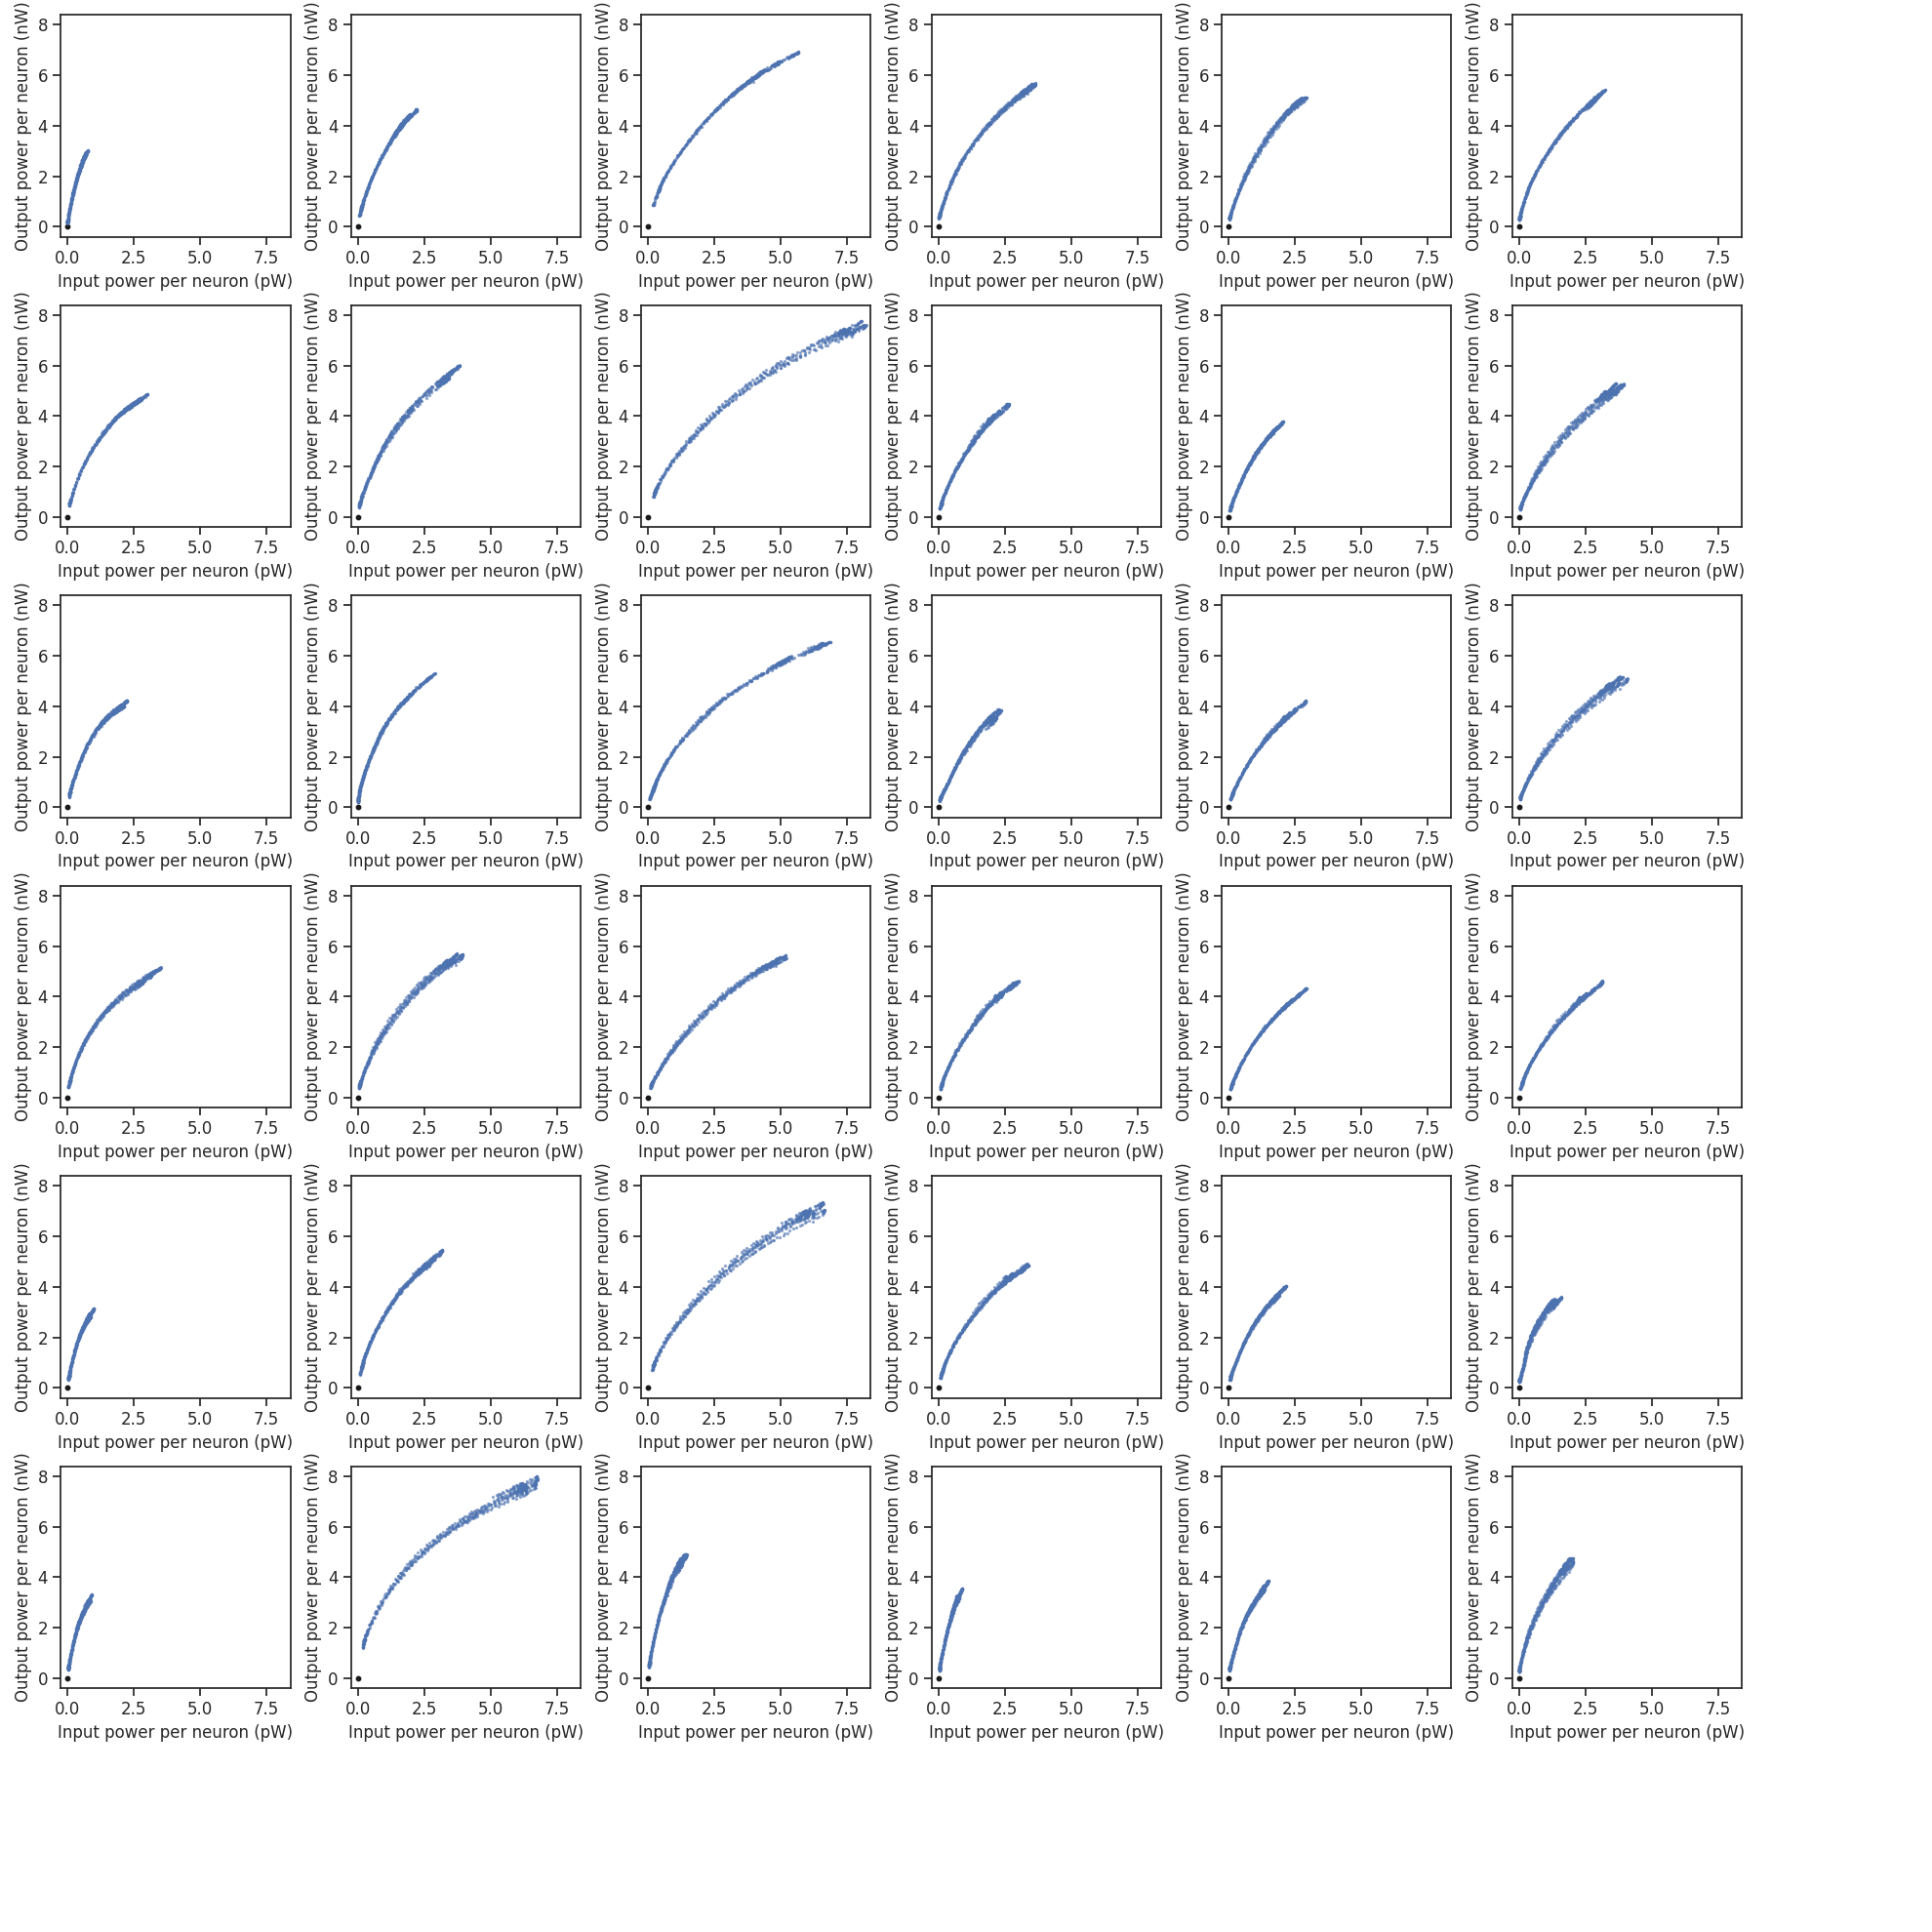

[-0.01900633  2.19906167  3.69041306  2.19605554]
[ 0.3353407  17.58436888  5.8255496   0.60928191]


/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.


[0.86825427 4.18706374 7.94266101 0.25213519]
[ 6.44623767  0.42077066  0.55073082 21.00310333]
[ 0.3456991  35.0185028   6.41004524  0.47973883]
[ 0.59240007 21.56720273  6.32540607  0.42787789]
[ 5.22894492  0.57846221  0.50664911 10.26904642]
[ 6.78609674  0.40736394  0.51530034 13.93690829]
[8.76888731 0.17286272 0.97675106 3.77603793]
[ 5.73832338  0.48302777  0.32258119 14.34679263]
[ 4.97600528  0.61432662  0.19357277 26.59669859]
[ 0.42658969 18.85332266  6.81028871  0.31448526]
[ 4.42356485  0.91285382  0.27993045 24.82339541]
[ 0.51722511 37.15540905  5.5193738   0.65274257]
[7.17421066 0.22045057 0.93615073 3.13677008]
[5.12500302e+00 5.39999723e-01 1.38502641e-01 3.31858939e+02]
[5.64173458 0.3974288  0.31196425 9.75426748]
[ 0.46240613 16.55742891  6.57940065  0.308243  ]
[5.25016025 0.45333626 0.87873217 7.8404488 ]
[ 6.57005831  0.3872046   0.51554415 13.26777465]
[7.0512212  0.25510417 0.40992099 9.78387957]
[ 0.31539495 10.69649015  5.80192352  0.44750403]
[0.41593585 

In [566]:
from scipy.optimize import curve_fit

def func2(x, b, c, d, e):
    return (-1.*b*np.exp(-c*x) - d*np.exp(-e*x) + b + d)

coeffs_refit = np.load('./Nonlinearity_Curves_April_8_data_refit.npz')['coeffs']

fig, axes = plt.subplots(6, 6, figsize = (18, 18))
x0 = torch.arange(0, 8, 0.1)
p0s = np.ones((36,4))
coeffs_new = np.zeros(p0s.shape)
px2power_before_int = lambda x:x/0.35/0.6/0.1*3.6E-19*1E12
for k in range(36):
    i = k//6
    j = k%6
    ax = axes[i,j]
#     ax.plot(x0, y0s[:,k], 'r')
    ax.scatter(0, 0, s=10, c='k')
    x = px2power_before_int(train_fc1[:,k])
    y = px2power_before_int(train_act1[:,k])*3.5
    ax.scatter(x, y, s=2, alpha=0.5)
    ax.set_xlabel('Input power per neuron (pW)')
    ax.set_ylabel('Output power per neuron (nW)')
    popt, _ = curve_fit(func2, x, y, p0=p0s[k,:], maxfev=5000)
    print(popt)
    coeffs_new[k,:] = popt
#     ax.plot(x0, func2(x0, *coeffs_new[k,:]), 'r-')
    ax.set_ylim(-0.4,8.4)
    ax.set_xlim(-0.25, 8.4)

        #ax[i, j].set_xticks([])
        #ax[i, j].set_yticks([])
#plt.savefig('Old_intensifier_nonlinearity', dpi = 1200)
plt.tight_layout()
plt.show()

plt.savefig(f"./Figures/Speedlimit_nonlinear_curves_no_fit.png", dpi=400, format="png")

<IPython.core.display.Javascript object>


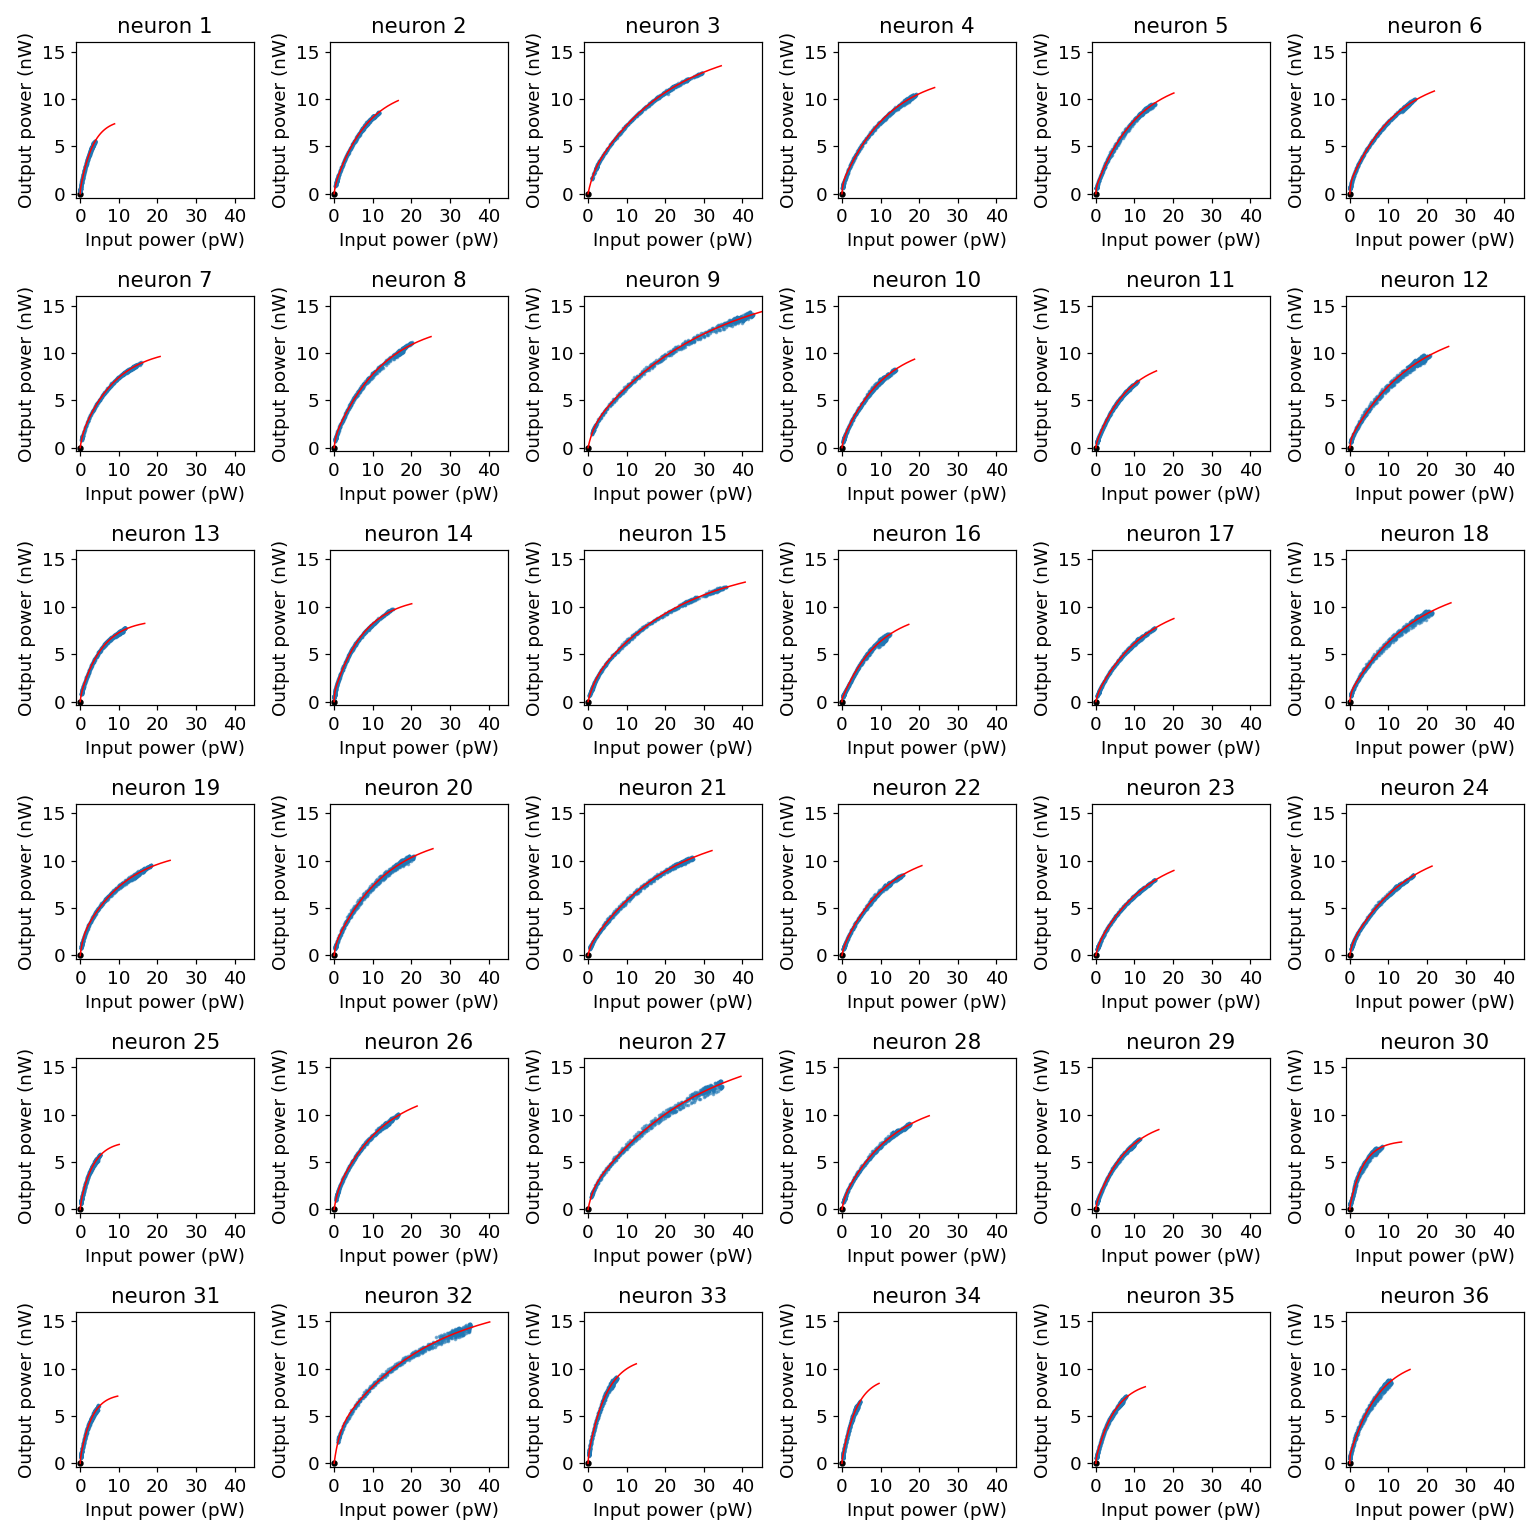

/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.


[ 0.38637801 49.5930598   7.51604466  0.30012532]


/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


[10.76127839  0.11681241  0.61946083  3.37128468]
[14.67212215  0.04833975  1.60388652  0.80275103]
[11.90785319  0.08067058  1.0173469   4.02666264]
[11.84098312  0.09197646  0.63858996  6.71399213]
[11.68463374  0.08203356  1.09431021  4.13494317]
[9.65919636 0.11090364 0.93591084 1.96879487]
[ 0.95190793  2.67187587 12.53566747  0.07809996]
[16.1983746   0.0331415   1.80430965  0.72394686]
[10.60014932  0.09260679  0.59589054  2.75058027]
[0.35757844 5.0991539  9.19195238 0.11777963]
[12.58031513  0.06029398  0.78800826  3.614774  ]
[8.1714537  0.17501373 0.51710304 4.75917864]
[10.19569153  0.12514489  0.95544519  7.12353717]
[ 1.72929967  0.60139111 13.25259327  0.04226524]
[ 0.25584974 63.28889301  9.46718904  0.10352957]
[ 0.57627292  1.87013494 10.42171475  0.07619587]
[12.15383654  0.05909676  0.85418393  3.17439424]
[9.69839544 0.0869137  1.62326046 1.5031536 ]
[ 0.95234283  2.5437091  12.13657611  0.07423543]
[13.02540331  0.048909    0.75722707  1.87579275]
[ 0.58261536  2.

In [67]:
from scipy.optimize import curve_fit

def func2(x, b, c, d, e):
    return (-1.*b*np.exp(-c*x) - d*np.exp(-e*x) + b + d)

coeffs_refit = np.load('./Nonlinearity_Curves_April_8_data_refit.npz')['coeffs']

fig, axes = plt.subplots(6, 6, figsize = (14, 14))
# x0 = torch.arange(0, 40, 0.1)
p0s = np.ones((36,4))
coeffs_new = np.zeros(p0s.shape)
px2power_before_int = lambda x:(x*8.94154E-8)*1E3 #unit: pW
px2power_after_int = lambda x:(x*4.54709E-6)*19.5/0.8 #unit: nW
for k in range(36):
    i = k//6
    j = k%6
    ax = axes[i,j]
#     ax.plot(x0, y0s[:,k], 'r')
    ax.scatter(0, 0, s=10, c='k')
    x = px2power_before_int(train_fc1[:,k])
    y = px2power_after_int(train_act1[:,k])
    ax.scatter(x, y, s=2, alpha=0.5)
    ax.set_xlabel('Input power (pW)')
    ax.set_ylabel('Output power (nW)')
    popt, _ = curve_fit(func2, x, y, p0=p0s[k,:], maxfev=5000)
    print(popt)
    coeffs_new[k,:] = popt
    x0 = torch.range(0, x.max()+5, 0.1)
    ax.plot(x0, func2(x0, *coeffs_new[k,:]), 'r-', linewidth=1.0)
    ax.set_ylim(-0.4, 16)
    ax.set_xlim(-1, 45)
    ax.set_title(f"neuron {k+1}", fontsize=14)
    ax.set_xticks(np.arange(0,42,10))
    ax.set_yticks(np.arange(0,16,5))
    
#plt.savefig('Old_intensifier_nonlinearity', dpi = 1200)
plt.tight_layout()
plt.show()

plt.savefig(f"./Figures/Speedlimit_nonlinear_curves_Jun_26.svg", dpi=400, format="svg")

## Plot weights

In [68]:
weights = np.load("slims_nonlinear_1600_36_2_Apr_26_v159_ep2992.npz")

<IPython.core.display.Javascript object>


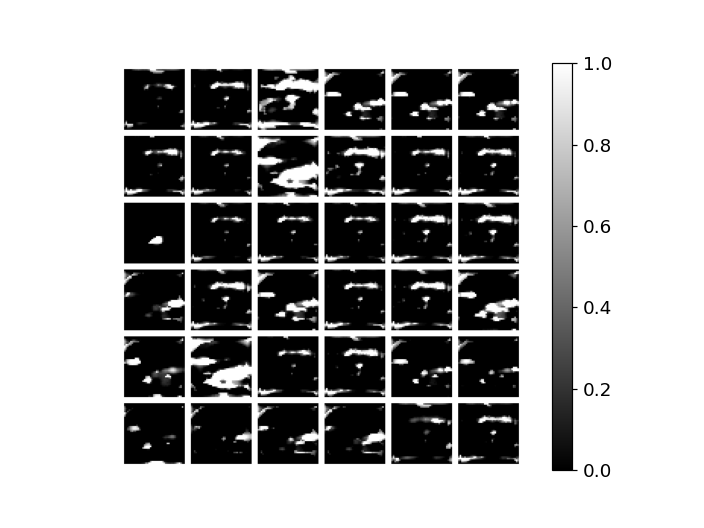

In [74]:
import torchvision

# W = model.fc1.W_Opt.to(device='cpu')
W = torch.tensor(weights["fc1_W_Opt"])
W = W.view(-1,1,40,40)
W = W.repeat(1,3,1,1)
W_vis = torchvision.utils.make_grid(W, padding=4, pad_value=1, nrow=6)
plt.figure()
plt.imshow(W_vis[0,:,:].detach().numpy(), cmap="gray")
plt.axis("off")
plt.colorbar()
plt.show()
plt.savefig(f"./Figures/Speedlimit_nonlinear_fc1_weights.svg", dpi=400, format="svg")

<IPython.core.display.Javascript object>


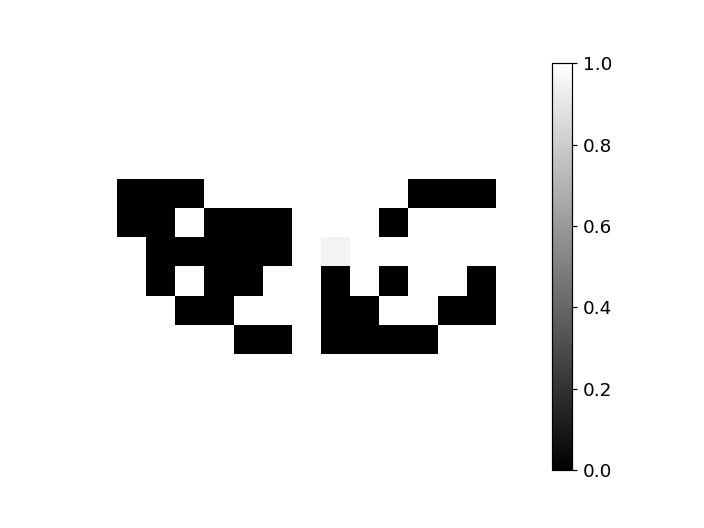

In [75]:
import torchvision
import matplotlib.pyplot as plt

model.to("cpu")
W = torch.tensor(weights["fc2_W_Opt"])
W = W.view(-1,1,6,6)
W = W.repeat(1,3,1,1)
W_vis = torchvision.utils.make_grid(W, padding=1, pad_value=1, nrow=2)
plt.figure()
plt.imshow(W_vis[0,:,:].detach().numpy(), cmap="gray")
plt.axis("off")
plt.colorbar(ticks=np.arange(0,1.2,0.2))
plt.show()
plt.savefig(f"./Figures/Speedlimit_nonlinear_fc2_weights.svg", dpi=400, format="svg")

In [33]:
print(torch.__version__, optuna.__version__, ray.__version__)

1.11.0+cu102 1.5.0 1.11.0
